# Bottleneck nonlinear network for lower dimensional presentations of multimodal datasets

In [1]:
# Import packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib
import seaborn as sns
import sparseRRR
import matplotlib
import matplotlib.pyplot as plt
import importlib

import bottleneck_networks

import time
import pickle
import warnings

dtype = tf.float32

#####################################################
# Sigmoid function for transformations  
def sigmoid(x, offset = 1, steepness = 1):
    # offset to shift the sigmoid centre to 1
    return 1/(1 + np.exp(-steepness*(x-offset)))

def sns_styleset():
    sns.set_style('ticks', {'axes.linewidth': .75, "xtick.major.size":4, "ytick.major.size":4})

# Loading data and preprocessing

In [2]:
# LOAD ALL THE DATA FROM THE ORIGINAL FILES
data = pd.read_csv("M1Data/M1_combined_counts.tab", sep='\t')
counts = data.values[:,1:].transpose().astype(float)
genes = data.values[:,0]
cells = np.array(data.columns[1:])

## Attach Shipment 9 (different assembly)

data = pd.read_csv("M1Data/shp_9_M1_counts.tab", sep='\t')
counts2 = data.values[:,1:].transpose().astype(float)
genes2 = data.values[:,0]
cells2 = np.array(data.columns[1:])

data = pd.read_csv("M1Data/shp_10_counts.txt", sep='\t')
data1 = pd.read_csv('M1Data/patch_seq_11_counts.txt', sep='\t')
counts3 = data.values[:,1:].transpose().astype(float)
counts4 = data1.values[:,1:].transpose().astype(float)
genes3 = data.values[:,0]
genes4 = data1.values[:,0]
cells3 = np.array(data.columns[1:])
cells4 = np.array(data1.columns[1:])
cells3 = np.array([c.lower() for c in cells3])
cells4 = np.array([c.lower() for c in cells4])
assert(np.all(genes2==genes3))
assert(np.all(genes2==genes4))
counts2 = np.concatenate((counts2, counts3, counts4), axis=0)
cells2 = np.concatenate((cells2, cells3, cells4), axis=0)

counts2_resorted = np.zeros((counts2.shape[0], counts.shape[1]))
genes_map = np.array([[i, np.where(genes2==g)[0][0]] for i,g in enumerate(genes) if g in genes2])
counts2_resorted[:, genes_map[:,0]] = counts2[:, genes_map[:,1]]

counts = np.concatenate((counts, counts2_resorted), axis=0)
cells = np.concatenate((cells, cells2))

## End attach

goodReseq = [('reseq' in c) and (int(c[:6])>=201809) and (int(c[:6])<=201811) for c in cells]
badReseq = np.isin(['_'.join(c.split('_')[:3]) for c in cells], 
                   ['_'.join(c.split('_')[:3]) for c in cells[goodReseq]]) & ~np.array(goodReseq)
counts = counts[~badReseq]
cells[goodReseq] = [c[:-12] for c in cells[goodReseq]]
cells = cells[~badReseq]

selection = [i for i,c in enumerate(cells) if 'BLANK' not in c and 'Blank' not in c 
             and 'blank' not in c and 'resequenced' not in c and 'lowyield' not in c
             and 'undetermined' not in c]
counts = counts[selection,:]
cells  = cells[selection]


rpkm = pd.DataFrame(counts, cells, columns = genes)
rpkm = rpkm.T

all cells with transcriptimic data:  (24490, 1320)
cells with ephys properties:  1319
cell with genetic but no ephys properties:  20190211sample10
cells with ephys after elimination of cells with no rna-seq data:  1319
cells with ephys properties after exclusion of certain cells
(Nan ephys property or ephys and rna don't match):  1312
All cells with ephys + transcriptomic data (after exclusion of Nan ephys property data:  (24490, 1304)
Chosen offset: 7.57
RPKM shape: (1304, 1000)
ephys shape: (1304, 16)
cellTypes shape: (1304,)
ephys properties: AP amp, AP amp adapt, AP amp CV, AP thresh, AP width, AHP, ISI adapt, ISI CV, R_i, Max number of APs, Tau, Rebound, Vm, Rheobase, Sag, UDR
genes: Erbb4, Thsd7b, Atp6v1h, Sulf1, Col19a1, Plekhb2, Ndufs1, Epha4, Serpine2, Dner ...


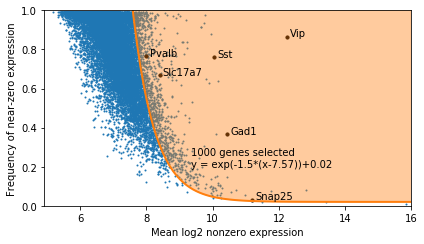

In [3]:
amount_of_genes = 1000

new_keys = ['{}{}{}'.format(g.split('_')[0], g.split('_')[1], g.split('_')[2]) \
            for g in rpkm.keys().tolist()] # Changing column names
rpkm.columns = new_keys


print('all cells with transcriptimic data: ', rpkm.shape)

M1_ephys = pd.read_csv('M1Data/Cell_Features_M1.csv')
M1_ephys = M1_ephys.drop(['Unnamed: 0'], axis=1)
ephysProperties = ['AP amp FF', 'AP amp', 'AP amp adapt', 'AP amp average adapt', 'AP amp CV', 'AP thresh', \
                   'AP width', 'ADP', 'AHP', 'Burstiness', 'ISI FF',
                    'ISI adapt', 'ISI average adapt', 'ISI CV', 'R_i', 'Latency', 'Max number of APs', 'Tau',
                   'Rebound',  'Rebound number of APs', 'Vm', 'Rheobase', 'Sag area', 'Sag', 'Sag time', \
                   'SFA', 'UDR', 'Wildness']

# Cells for which ephys properties are available:
cells_w_ephys = ['{}{}{}{}{}'.format(g.split('/')[-1].split(' ')[2], g.split('/')[-1].split(' ')[0], \
                                     g.split('/')[-1].split(' ')[1], 'sample', \
                                     g.split('/')[-1].split(' ')[-1].split('.')[0]) \
                  for g in M1_ephys['name sample'].tolist()]

M1_ephys['Name sample'] = cells_w_ephys
M1_ephys = M1_ephys.drop(['name sample'], axis = 1)
M1_ephys = M1_ephys.rename(columns = {'Name sample': 'name sample'})
M1_ephys = M1_ephys.set_index('name sample')

M1_ephys.columns = ephysProperties

print('cells with ephys properties: ', len(cells_w_ephys))

# Find the cells first for which ephys properties are available but no genetic properties.
# Delete these from cells_w_ephys
no_gene = []
for cell in cells_w_ephys:
    if cell not in rpkm.columns:
        print('cell with ephys but no genetic properties: ', cell)
        no_gene.append(cell)
for cell in no_gene:
    cells_w_ephys.remove(cell)

no_ephys = []
for cell in rpkm.keys():
    if cell not in M1_ephys.index:
        print('cell with genetic but no ephys properties: ', cell)
        no_ephys.append(cell)
# Scrap the ephys cells for which no genetic info exists
M1_ephys = M1_ephys.loc[cells_w_ephys]
print('cells with ephys after elimination of cells with no rna-seq data: ', len(cells_w_ephys))


# Drop cells where the ephys and rna don't match
M1_ephys = M1_ephys.drop(['20180315sample6'], axis = 0) # FS firing but excitatory RNA
M1_ephys = M1_ephys.drop(['20180321sample4'], axis = 0) # MC firing and morphology but excitatory RNA
M1_ephys = M1_ephys.drop(['20181116sample10'], axis = 0) # FS firing but excitatory RNA
M1_ephys = M1_ephys.drop(['20190325sample2'], axis = 0) # FS firing but excitatory RNA
M1_ephys = M1_ephys.drop(['20190611sample1'], axis = 0) # mismatch (L1 firing and morphology but excitatory RNA)
M1_ephys = M1_ephys.drop(['20190611sample11'], axis = 0) # mismatch (L1 firing and morphology but excitatory RNA)
M1_ephys = M1_ephys.drop(['20190704sample2'], axis = 0) # outside of M1



print("cells with ephys properties after exclusion of certain cells\n(Nan ephys property or ephys and rna don't match): ", \
              len(M1_ephys.index))

# Feature transformations
# According to the stripplot, certain transformations of some properties are in place
M1_ephys = M1_ephys.drop('SFA', axis = 1)
M1_ephys['ISI adapt'] = np.log(M1_ephys['ISI adapt'])
M1_ephys['ISI average adapt'] = sigmoid(M1_ephys['ISI average adapt'], offset = 1, steepness = 2)
M1_ephys['ISI FF'] = np.log(M1_ephys['ISI FF'])
M1_ephys['ISI CV'] = np.log(M1_ephys['ISI CV'])
M1_ephys['AP amp CV'] = np.log(M1_ephys['AP amp CV'])
M1_ephys['AP amp FF'] = np.log(M1_ephys['AP amp FF'])
M1_ephys['AP amp average adapt'] = sigmoid(M1_ephys['AP amp average adapt'], offset = 1, steepness = 50)
M1_ephys['Latency'] = np.log(M1_ephys['Latency'])

select = True # Set to True if you'd like to drop certain features for certain reasons
if select: #!!!!! Make sure that SFA is already dropped
    M1_ephys = M1_ephys.drop('ADP', axis=1) # too much of a 0 or something feature
    M1_ephys = M1_ephys.drop('Sag time', axis=1) # sag should be meaningfull enough (we don't want too many corr.)
                                                           # it also has too many 0's
    M1_ephys = M1_ephys.drop('Sag area', axis=1) # sag should be meaningfull enough (we don't want too many corr.)
                                                           # it also has too many 0's
    M1_ephys = M1_ephys.drop('AP amp FF', axis=1) # the log is heavily correlated with log(AP_cv)
    M1_ephys = M1_ephys.drop('ISI FF', axis=1) # the log is heavily correlated with log(cv)
    M1_ephys = M1_ephys.drop('Wildness', axis=1) # too much of a 0 or something feature
    M1_ephys = M1_ephys.drop('Rebound number of APs', axis=1) # too much of a 0 or something feature
    M1_ephys = M1_ephys.drop('ISI average adapt', axis=1) # too skewed of a feature
    M1_ephys = M1_ephys.drop('AP amp average adapt', axis=1) # too skewed of a feature
    M1_ephys = M1_ephys.drop('Burstiness', axis=1) # too many cells have zero for this feature
    M1_ephys = M1_ephys.drop('Latency', axis=1) # too many outliers

ephysProperties = M1_ephys.keys()

M1_ephys = M1_ephys.dropna() # We drop Nans here because SFA causes too many Nans and we don't want to lose too much data

# Now delete all the cells with genetic data for which no ephys properties exist
rpkm = rpkm[list(M1_ephys.index)]

# Remember rpkm has the cells for which there's ephys + transcriptomic data and for which you could geneSelection
# in the future too for a subset of cells!
print('All cells with ephys + transcriptomic data (after exclusion of Nan ephys property data: ', rpkm.shape)


# We choose n most variable genes based on an heuristic appoach employed by Dmitry et al. in "The art
markerGenes = ['Snap25', 'Gad1', 'Slc17a7', 'Pvalb', 'Sst', 'Vip']
selectedGenes = sparseRRR.geneSelection(rpkm.T.values.astype(np.float), n=amount_of_genes, threshold=30, \
                                          markers=markerGenes, genes=np.array(list(rpkm.index)))
rpkm_all = rpkm.loc[selectedGenes, :]

geneNames = np.array(list(rpkm_all.index))
#rpkm_all = rpkm_all.dropna() # Drop all genes/rows for which Nan values exist
M1_ephys = M1_ephys.reindex(rpkm_all.columns)
cells_w_ephys = list(M1_ephys.index)
X_rpkm = rpkm_all.values.astype(np.float).T
ephysData = M1_ephys.values.astype(np.float)


# Now specify for all the cells left what the cell type is (according to transcriptomic mappings)
prop = pd.read_csv('M1Data/mini-atlas-meta-data.csv', sep = '\t')
prop = prop.rename(columns = {'Sample': 'sample_id', 'Targeted layer': 'Layer'})
prop = prop[['Cell', 'RNA type', 'sample_id', 'Layer', 'Cre', 'RNA type top-3']]
#sample_name = ['{}{}{}'.format(g.split(' ')[0], 'sample', g.split(' ')[-1]) \
#               for g in (prop['Cell'].map(str.strip) + prop['sample_id'].map(str.strip)).tolist()]
sample_name = ['{}{}{}'.format(g.split('_')[0], g.split('_')[1], g.split('_')[2]) for g in prop['Cell']]
prop['sample name'] = sample_name
prop = prop.set_index('sample name')

prop = prop.reindex(M1_ephys.index) # There could be more cells with ephys than manually labelled
                                    # They will receive the Nan property
prop = prop.fillna('')
#M1_Allen_Mapping = np.array([g.split(',')[0].split('(')[0][:-1] if ',' in g else g.split('(')[0][:-1] \
#                             for g in prop['RNA type top-3']])
M1_Allen_Mapping = prop['RNA type']
M1_Allen_Mapping[np.where(M1_Allen_Mapping == '')[0]] = 'low quality'
number_labels = {c: i for i, c in enumerate(np.unique(M1_Allen_Mapping))}
cellTypes = np.array([number_labels[cell_type] for cell_type in M1_Allen_Mapping])

# Double-check
print('RPKM shape:', X_rpkm.shape)
print('ephys shape:', ephysData.shape)
print('cellTypes shape:', cellTypes.shape)
#print('cellClasses shape: ', cell_classes.shape)
print('ephys properties:', ', '.join(ephysProperties))
print('genes:', ', '.join(geneNames[:10]), '...')

In [4]:
cellTypeColors = {'Lamp5 Pax6': '#DDACC9',
 'Lamp5 Egln3_1': '#FF88AD',
 'Lamp5 Egln3_2': '#DD8091',
 'Lamp5 Egln3_3': '#F08E98',
 'Lamp5 Pdlim5_1': '#FF7290',
 'Lamp5 Pdlim5_2': '#FF8C97',
 'Lamp5 Slc35d3': '#FFA388',
 'Lamp5 Lhx6': '#C77963',
 'Sncg Col14a1': '#7E0ACB',
 'Sncg Slc17a8': '#9440F3',
 'Sncg Calb1_1': '#9611B6',
 'Sncg Calb1_2': '#9900B3',
 'Sncg Npy2r': '#7A0099',
 'Vip Sncg': '#AA4DB5',
 'Vip Serpinf1_1': '#A720FF',
 'Vip Serpinf1_2': '#AB1DFF',
 'Vip Serpinf1_3': '#FF5FCD',
 'Vip Htr1f': '#FF4DC1',
 'Vip Gpc3': '#B09FFF',
 'Vip C1ql1': '#BD3D9A',
 'Vip Mybpc1_1': '#F70CF3',
 'Vip Mybpc1_2': '#992E81',
 'Vip Mybpc1_3': '#AB379C',
 'Vip Chat_1': '#FF00FF',
 'Vip Chat_2': '#B3128A',
 'Vip Igfbp6_1': '#7779BF',
 'Vip Igfbp6_2': '#626EB8',
 'Sst Chodl': '#FFFF00',
 'Sst Penk': '#FF8011',
 'Sst Myh8_1': '#FF9F2C',
 'Sst Myh8_2': '#FFB307',
 'Sst Myh8_3': '#FFBF09',
 'Sst Htr1a': '#BFAF00',
 'Sst Etv1': '#FFB22B',
 'Sst Pvalb Etv1': '#D9C566',
 'Sst Crhr2_1': '#BE8652',
 'Sst Crhr2_2': '#B0993C',
 'Sst Hpse': '#CDB115',
 'Sst Calb2': '#D2A328',
 'Sst Pvalb Calb2': '#784F14',
 'Sst Pappa': '#635821',
 'Sst C1ql3_1': '#802600',
 'Sst C1ql3_2': '#8A2B1A',
 'Sst Tac2': '#804600',
 'Sst Th_1': '#8C6012',
 'Sst Th_2': '#A81111',
 'Sst Th_3': '#9B211B',
 'Pvalb Gabrg1': '#ED4C50',
 'Pvalb Egfem1': '#C05661',
 'Pvalb Gpr149': '#E62A5D',
 'Pvalb Kank4': '#BC4B11',
 'Pvalb Calb1_1': '#B6411E',
 'Pvalb Calb1_2': '#BC2D71',
 'Pvalb Reln': '#9C4165',
 'Pvalb Il1rapl2': '#BC2C41',
 'Pvalb Vipr2_1': '#FF197F',
 'Pvalb Vipr2_2': '#F4358B',
 'L2/3 IT_1': '#00FF34',
 'L2/3 IT_2': '#07D945',
 'L2/3 IT_3': '#2EB934',
 'L4/5 IT_1': '#09CCC6',
 'L4/5 IT_2': '#52B8AA',
 'L5 IT_1': '#58D2C1',
 'L5 IT_2': '#4A9F93',
 'L5 IT_3': '#4EAC9C',
 'L5 IT_4': '#52B4B8',
 'L6 IT_1': '#B2AD23',
 'L6 IT_2': '#81791F',
 'L6 IT Car3': '#5100FF',
 'L5 PT_1': '#0D5D7E',
 'L5 PT_2': '#0B77A5',
 'L5 PT_3': '#0B8AA5',
 'L5 PT_4': '#0A75B1',
 'L5/6 NP_1': '#48CB80',
 'L5/6 NP_2': '#3C78BC',
 'L5/6 NP_3': '#47867A',
 'L5/6 NP CT': '#1AAB99',
 'L6 CT Gpr139': '#168577',
 'L6 CT Cpa6': '#338C5E',
 'L6 CT Grp': '#2FBCE5',
 'L6 CT Pou3f2': '#3E766C',
 'L6 CT Kit_1': '#516B78',
 'L6 CT Kit_2': '#557361',
 'L6b Col6a1': '#69419D',
 'L6b Shisa6_1': '#46306A',
 'L6b Shisa6_2': '#464576',
 'L6b Ror1': '#7044AA',
 'L6b Kcnip1': '#573D90'}

# Normalization of data

In [5]:
def preprocess(ephysData, rpkm, cellTypes, ind, amount_of_genes = 1000):
    """Preprocess subset of the data in a systematic manner (library normalization, gene selection, Z-scoring)"""
    Y = ephysData[ind, :]
    cellTypes = cellTypes[ind]

    # Getting the transcriptomic data right
    rpkm = rpkm.T.loc[ind, :].T

    # Select amount_of_genes most variable genes
    selectedGenes = sparseRRR.geneSelection(rpkm.T.values.astype(np.float), n=amount_of_genes, threshold=30, \
                                              markers=markerGenes, genes=np.array(list(rpkm.index)))
    rpkm = rpkm.loc[selectedGenes]

    geneNames = np.array(list(rpkm.index))
    X = rpkm.values.astype(np.float).T


    X = X / np.sum(X, axis=1, keepdims=True) * \
                    np.median(np.sum(X, axis=1, keepdims=True))


    # Log-transform
    X = np.log2(X + 1)

    # Sort out cells with nans in the transcriptomic data
    ind_non_nan = ~np.isnan(np.sum(X, axis=1))
    X = X[ind_non_nan, :]
    Y = Y[ind_non_nan, :]
    cellTypes = cellTypes[ind_non_nan]

    # Standardize Y
    mu = np.mean(Y, axis=0)
    Y = Y - mu
    sigma = np.std(Y, axis=0)
    Y = Y / sigma

    # Standardize X
    mu = np.mean(X, axis=0)
    X = X - mu
    sigma = np.std(X, axis=0)
    X = X / sigma
    return X, Y, cellTypes, geneNames

Chosen offset: 7.53


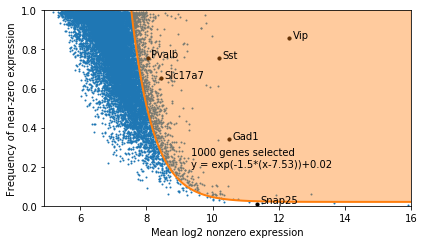

In [6]:
# This is the non-permutation sensitive part and always the same. You can rerun this all the time.

X_no_low_qual, Y_no_low_qual, cellTypes_no_low_qual, geneNames = preprocess(ephysData, rpkm, cellTypes, cellTypes!=77)
X_no_low_qual = X_no_low_qual.astype('float32')
Y_no_low_qual = Y_no_low_qual.astype('float32')

In [7]:
cellTypeLabels = {i: c for i, c in enumerate(np.unique(M1_Allen_Mapping))}
amount_of_cells = {cell_type: sum(M1_Allen_Mapping==cell_type) for cell_type in np.unique(M1_Allen_Mapping)}
for_every_cell_number_of_cells_of_their_celltype = np.array([amount_of_cells[cellTypeLabels[c]] for c in cellTypes_no_low_qual])
ind_pre_training = for_every_cell_number_of_cells_of_their_celltype >= 10

Let us find K-mean clusters to perform pre-training. One could also pre-train on celltype classification. This has actually improved performance even more but could be argued to be biasing the results too much. K-means allows for an unsupervised more general setting.

In [8]:
# You can cluster according to amounts of classes or amounts of celltypes. Change the argument of n_clusters accordingly.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=17, n_init=1000).fit(Y_no_low_qual)

In [9]:
clusters = kmeans.labels_

In [10]:
amount_of_cells_in_clusters = {cluster_id: sum(clusters==cluster_id) for cluster_id in np.unique(clusters)}
for_every_cell_number_of_cells_of_their_cluster = np.array([amount_of_cells_in_clusters[cell] for cell in clusters])
ind_pre_training_clusters = for_every_cell_number_of_cells_of_their_cluster >= 10

In [11]:
# So that we have other colours too that distinguish well among each other (for the clusters)
clusterCols = ["#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
       "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
       "#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
       "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
       "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
       "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
       "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
       "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
       "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
       "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
       "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
       "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
       "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
       "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
       "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
       "#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58"]

# Keras initialisations

In [12]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

In [14]:
def r2_score(y_truth, y_pred):
    residual = tf.add(y_truth, -y_pred, name='residual')
    return 1-tf.reduce_sum(tf.square(residual)) / tf.reduce_sum(tf.square(y_truth))

In [15]:
class ElasticNet(tf.keras.regularizers.Regularizer): 
    def __init__(self, l1=1e-8, l2=1.0): 
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x): 
        return self.l2*tf.math.reduce_sum(tf.math.square(x)) + \
                             self.l1*tf.reduce_sum(tf.norm(x, ord = 2, axis = 1))

    def get_config(self): 
        return {'l1': float(self.l1), 'l2': float(self.l2)}

# Latent space visualization of favourite models

First we train the lasso 1e-1 freeze (4 last layers) unfreeze model for the entire dataset.

In [17]:
from bottleneck_networks import ClassificationPreTrain

In [18]:
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs


t = time.time()
np.random.seed(seed)
n = X_no_low_qual.shape[0]
X = np.copy(X_no_low_qual)
Y = np.copy(Y_no_low_qual)
clusters_ = np.copy(clusters)

CE_loss = np.zeros((l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((l1_params.shape[0], l2_params.shape[0], epochs))


pre_train_size = 0.6
train_cnt = round(X.shape[0]*pre_train_size)
x_train_pre_tr_ = X[:train_cnt, :]
x_test_pre_tr_ = X[train_cnt:, :]
clusters_train_pre_tr_ = clusters_[:train_cnt]
clusters_test_pre_tr_ = clusters_[train_cnt:]

for i, l2 in enumerate(l2_params):
    print('ridge penalty: ', l2)
    for j, l1 in enumerate(l1_params):
        print('lasso penalty: ', l1)


        input_dim = x_train_pre_tr_.shape[1]
        output_dim = to_categorical(clusters_train_pre_tr_).shape[1]
        BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                   output_dim=output_dim)
        # random cvfold_id number to make sure we don't mess with our cv results and that this is for the full dataset
        CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                           cluster_train=clusters_train_pre_tr_, \
                                                                           x_test=x_test_pre_tr_, \
                                                                           cluster_test=clusters_test_pre_tr_, \
                                                                           epochs=epochs, bs=bs, patience=patience, \
                                                                           cvfold_id=1000, l1_id=j, l2_id=i)
        CE_loss[j, i] = CE_test
        CE_loss_tr[j, i] = CE_train
        pre_tr_hist[j, i] = test_hist
        pre_tr_hist_tr[j, i] = train_hist
        print('Test CE loss (pre-training): ', CE_loss[j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

ridge penalty:  1e-10
lasso penalty:  0.1
Instructions for updating:
Colocations handled automatically by placer.
[INFO] training network...
Train on 728 samples, validate on 485 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
512/728 [====================>.........] - ETA: 0s - loss: 83.8764 - categorical_crossentropy: 2.9675
Epoch 00001: val_categorical_crossentropy improved from inf to 2.87571, saving model to KerasSavedModels/Classification_weights_2000_0_0.h5
728/728 [==============================] - 1s 1ms/sample - loss: 83.2239 - categorical_crossentropy: 2.9441 - val_loss: 80.9080 - val_categorical_crossentropy: 2.8757
Epoch 2/50
576/728 [======================>.......] - ETA: 0s - loss: 79.1663 - categorical_crossentropy: 2.6771
Epoch 00002: val_categorical_crossentropy improved from 2.87571 to 2.68464, saving model to KerasSavedModels/Classification_weights_2000_0_0.h5
728/728 [==============================] - 0s 316us/sample - loss: 78.6820 - categorical

Epoch 21/50
512/728 [====================>.........] - ETA: 0s - loss: 13.5977 - categorical_crossentropy: 1.2884
Epoch 00021: val_categorical_crossentropy did not improve from 2.43109
728/728 [==============================] - 0s 292us/sample - loss: 13.2788 - categorical_crossentropy: 1.3204 - val_loss: 13.6132 - val_categorical_crossentropy: 2.9031
Epoch 22/50
512/728 [====================>.........] - ETA: 0s - loss: 11.2731 - categorical_crossentropy: 1.3023
Epoch 00022: val_categorical_crossentropy did not improve from 2.43109
728/728 [==============================] - 0s 300us/sample - loss: 10.9954 - categorical_crossentropy: 1.3510 - val_loss: 11.4325 - val_categorical_crossentropy: 2.9508
Epoch 23/50
544/728 [=====================>........] - ETA: 0s - loss: 9.0321 - categorical_crossentropy: 1.2826
Epoch 00023: val_categorical_crossentropy did not improve from 2.43109
728/728 [==============================] - 0s 280us/sample - loss: 8.8104 - categorical_crossentropy: 1.3178

Epoch 45/50
512/728 [====================>.........] - ETA: 0s - loss: 2.1601 - categorical_crossentropy: 1.5080
Epoch 00045: val_categorical_crossentropy did not improve from 2.43109
728/728 [==============================] - 0s 297us/sample - loss: 2.2160 - categorical_crossentropy: 1.5638 - val_loss: 3.2458 - val_categorical_crossentropy: 2.6008
Epoch 46/50
512/728 [====================>.........] - ETA: 0s - loss: 2.1679 - categorical_crossentropy: 1.5104
Epoch 00046: val_categorical_crossentropy did not improve from 2.43109
728/728 [==============================] - 0s 281us/sample - loss: 2.2186 - categorical_crossentropy: 1.5596 - val_loss: 3.2768 - val_categorical_crossentropy: 2.6161
Epoch 47/50
576/728 [======================>.......] - ETA: 0s - loss: 2.1678 - categorical_crossentropy: 1.5101
Epoch 00047: val_categorical_crossentropy did not improve from 2.43109
728/728 [==============================] - 0s 274us/sample - loss: 2.2025 - categorical_crossentropy: 1.5459 - val

Epoch 16/50
704/728 [============================>.] - ETA: 0s - loss: 26.8494 - categorical_crossentropy: 1.3178
Epoch 00016: val_categorical_crossentropy did not improve from 2.24275
728/728 [==============================] - 0s 316us/sample - loss: 26.8032 - categorical_crossentropy: 1.3219 - val_loss: 26.2831 - val_categorical_crossentropy: 2.4074
Epoch 17/50
704/728 [============================>.] - ETA: 0s - loss: 23.8124 - categorical_crossentropy: 1.2981
Epoch 00017: val_categorical_crossentropy did not improve from 2.24275
728/728 [==============================] - 0s 307us/sample - loss: 23.7624 - categorical_crossentropy: 1.2967 - val_loss: 23.3692 - val_categorical_crossentropy: 2.4565
Epoch 18/50
704/728 [============================>.] - ETA: 0s - loss: 20.8708 - categorical_crossentropy: 1.2745
Epoch 00018: val_categorical_crossentropy did not improve from 2.24275
728/728 [==============================] - 0s 308us/sample - loss: 20.8277 - categorical_crossentropy: 1.27

704/728 [============================>.] - ETA: 0s - loss: 47.2739 - categorical_crossentropy: 1.6663
Epoch 00010: val_categorical_crossentropy did not improve from 2.42621
728/728 [==============================] - 0s 304us/sample - loss: 47.2230 - categorical_crossentropy: 1.6735 - val_loss: 46.1762 - val_categorical_crossentropy: 2.4804
Epoch 11/50
704/728 [============================>.] - ETA: 0s - loss: 43.7226 - categorical_crossentropy: 1.6096
Epoch 00011: val_categorical_crossentropy did not improve from 2.42621
728/728 [==============================] - 0s 304us/sample - loss: 43.6736 - categorical_crossentropy: 1.6173 - val_loss: 42.7331 - val_categorical_crossentropy: 2.4884
Epoch 12/50
512/728 [====================>.........] - ETA: 0s - loss: 40.7118 - categorical_crossentropy: 1.5716
Epoch 00012: val_categorical_crossentropy did not improve from 2.42621
728/728 [==============================] - 0s 281us/sample - loss: 40.1994 - categorical_crossentropy: 1.5532 - val_los

728/728 [==============================] - 0s 336us/sample - loss: 70.0354 - categorical_crossentropy: 2.1449 - val_loss: 68.2857 - val_categorical_crossentropy: 2.4920
Epoch 5/50
512/728 [====================>.........] - ETA: 0s - loss: 66.5133 - categorical_crossentropy: 1.9998
Epoch 00005: val_categorical_crossentropy improved from 2.49201 to 2.43658, saving model to KerasSavedModels/Classification_weights_2003_0_0.h5
728/728 [==============================] - 0s 357us/sample - loss: 65.9642 - categorical_crossentropy: 2.0231 - val_loss: 64.3305 - val_categorical_crossentropy: 2.4366
Epoch 6/50
704/728 [============================>.] - ETA: 0s - loss: 62.0863 - categorical_crossentropy: 1.9397
Epoch 00006: val_categorical_crossentropy improved from 2.43658 to 2.40053, saving model to KerasSavedModels/Classification_weights_2003_0_0.h5
728/728 [==============================] - 0s 413us/sample - loss: 62.0175 - categorical_crossentropy: 1.9335 - val_loss: 60.4827 - val_categorical_

485/485 [==============================] - 0s 88us/sample - loss: 53.0842 - categorical_crossentropy: 2.3772
Test CE loss (pre-training):  53.0841689276941
ridge penalty:  1e-10
lasso penalty:  0.1
[INFO] training network...
Train on 728 samples, validate on 485 samples
Epoch 1/50
704/728 [============================>.] - ETA: 0s - loss: 83.2585 - categorical_crossentropy: 2.9179
Epoch 00001: val_categorical_crossentropy improved from inf to 2.89184, saving model to KerasSavedModels/Classification_weights_2004_0_0.h5
728/728 [==============================] - 1s 1ms/sample - loss: 83.1846 - categorical_crossentropy: 2.9140 - val_loss: 80.9282 - val_categorical_crossentropy: 2.8918
Epoch 2/50
704/728 [============================>.] - ETA: 0s - loss: 78.7165 - categorical_crossentropy: 2.5732
Epoch 00002: val_categorical_crossentropy improved from 2.89184 to 2.64606, saving model to KerasSavedModels/Classification_weights_2004_0_0.h5
728/728 [==============================] - 0s 397us/

Epoch 22/50
704/728 [============================>.] - ETA: 0s - loss: 10.5534 - categorical_crossentropy: 1.2075
Epoch 00022: val_categorical_crossentropy did not improve from 2.22627
728/728 [==============================] - 0s 321us/sample - loss: 10.5105 - categorical_crossentropy: 1.2029 - val_loss: 10.7750 - val_categorical_crossentropy: 2.6874
Epoch 23/50
672/728 [==========================>...] - ETA: 0s - loss: 8.3377 - categorical_crossentropy: 1.2021
Epoch 00023: val_categorical_crossentropy did not improve from 2.22627
728/728 [==============================] - 0s 315us/sample - loss: 8.2539 - categorical_crossentropy: 1.2002 - val_loss: 8.6999 - val_categorical_crossentropy: 2.7717
Epoch 24/50
640/728 [=========================>....] - ETA: 0s - loss: 6.3484 - categorical_crossentropy: 1.2463
Epoch 00024: val_categorical_crossentropy did not improve from 2.22627
728/728 [==============================] - 0s 329us/sample - loss: 6.2504 - categorical_crossentropy: 1.2630 - 

728/728 [==============================] - 0s 275us/sample - loss: 2.0797 - categorical_crossentropy: 1.4493 - val_loss: 3.0906 - val_categorical_crossentropy: 2.4671
Epoch 46/50
576/728 [======================>.......] - ETA: 0s - loss: 2.0803 - categorical_crossentropy: 1.4377
Epoch 00046: val_categorical_crossentropy did not improve from 2.22627
728/728 [==============================] - 0s 273us/sample - loss: 2.1227 - categorical_crossentropy: 1.4805 - val_loss: 3.1010 - val_categorical_crossentropy: 2.4554
Epoch 47/50
544/728 [=====================>........] - ETA: 0s - loss: 2.1403 - categorical_crossentropy: 1.4651
Epoch 00047: val_categorical_crossentropy did not improve from 2.22627
728/728 [==============================] - 0s 280us/sample - loss: 2.1468 - categorical_crossentropy: 1.4710 - val_loss: 3.2330 - val_categorical_crossentropy: 2.5505
Epoch 48/50
704/728 [============================>.] - ETA: 0s - loss: 2.1171 - categorical_crossentropy: 1.4308
Epoch 00048: val_c

704/728 [============================>.] - ETA: 0s - loss: 2.2312 - categorical_crossentropy: 1.4904
Epoch 00039: val_categorical_crossentropy did not improve from 2.25708
728/728 [==============================] - 0s 306us/sample - loss: 2.2385 - categorical_crossentropy: 1.4986 - val_loss: 3.0728 - val_categorical_crossentropy: 2.3589
Epoch 40/50
544/728 [=====================>........] - ETA: 0s - loss: 2.2743 - categorical_crossentropy: 1.5295
Epoch 00040: val_categorical_crossentropy did not improve from 2.25708
728/728 [==============================] - 0s 304us/sample - loss: 2.2837 - categorical_crossentropy: 1.5402 - val_loss: 3.1634 - val_categorical_crossentropy: 2.4204
Epoch 41/50
544/728 [=====================>........] - ETA: 0s - loss: 2.2014 - categorical_crossentropy: 1.4610
Epoch 00041: val_categorical_crossentropy did not improve from 2.25708
728/728 [==============================] - 0s 278us/sample - loss: 2.2134 - categorical_crossentropy: 1.4802 - val_loss: 3.071

Epoch 10/50
704/728 [============================>.] - ETA: 0s - loss: 46.8766 - categorical_crossentropy: 1.6081
Epoch 00010: val_categorical_crossentropy did not improve from 2.19643
728/728 [==============================] - 0s 312us/sample - loss: 46.8165 - categorical_crossentropy: 1.6064 - val_loss: 45.5518 - val_categorical_crossentropy: 2.2059
Epoch 11/50
480/728 [==================>...........] - ETA: 0s - loss: 43.8355 - categorical_crossentropy: 1.5523
Epoch 00011: val_categorical_crossentropy did not improve from 2.19643
728/728 [==============================] - 0s 302us/sample - loss: 43.2365 - categorical_crossentropy: 1.5384 - val_loss: 42.1119 - val_categorical_crossentropy: 2.2363
Epoch 12/50
480/728 [==================>...........] - ETA: 0s - loss: 40.3166 - categorical_crossentropy: 1.4807
Epoch 00012: val_categorical_crossentropy did not improve from 2.19643
728/728 [==============================] - 0s 302us/sample - loss: 39.7467 - categorical_crossentropy: 1.48

728/728 [==============================] - 0s 376us/sample - loss: 69.9554 - categorical_crossentropy: 2.0564 - val_loss: 68.1466 - val_categorical_crossentropy: 2.3519
Epoch 5/50
512/728 [====================>.........] - ETA: 0s - loss: 66.4580 - categorical_crossentropy: 1.9508
Epoch 00005: val_categorical_crossentropy improved from 2.35195 to 2.29244, saving model to KerasSavedModels/Classification_weights_2007_0_0.h5
728/728 [==============================] - 0s 366us/sample - loss: 65.8795 - categorical_crossentropy: 1.9487 - val_loss: 64.1591 - val_categorical_crossentropy: 2.2924
Epoch 6/50
704/728 [============================>.] - ETA: 0s - loss: 61.9594 - categorical_crossentropy: 1.8574
Epoch 00006: val_categorical_crossentropy improved from 2.29244 to 2.24076, saving model to KerasSavedModels/Classification_weights_2007_0_0.h5
728/728 [==============================] - 0s 394us/sample - loss: 61.8955 - categorical_crossentropy: 1.8568 - val_loss: 60.2567 - val_categorical_

Epoch 27/50
544/728 [=====================>........] - ETA: 0s - loss: 2.8024 - categorical_crossentropy: 1.4775
Epoch 00027: val_categorical_crossentropy did not improve from 2.17198
728/728 [==============================] - 0s 268us/sample - loss: 2.7956 - categorical_crossentropy: 1.5256 - val_loss: 3.3738 - val_categorical_crossentropy: 2.3082
Epoch 28/50
544/728 [=====================>........] - ETA: 0s - loss: 2.6342 - categorical_crossentropy: 1.5909
Epoch 00028: val_categorical_crossentropy did not improve from 2.17198
728/728 [==============================] - 0s 285us/sample - loss: 2.6922 - categorical_crossentropy: 1.6557 - val_loss: 3.6871 - val_categorical_crossentropy: 2.6837
Epoch 29/50
480/728 [==================>...........] - ETA: 0s - loss: 2.5605 - categorical_crossentropy: 1.5848
Epoch 00029: val_categorical_crossentropy did not improve from 2.17198
728/728 [==============================] - 0s 289us/sample - loss: 2.5679 - categorical_crossentropy: 1.6206 - val

485/485 [==============================] - 0s 96us/sample - loss: 45.5491 - categorical_crossentropy: 2.1720
Test CE loss (pre-training):  45.54914519319829
ridge penalty:  1e-10
lasso penalty:  0.1
[INFO] training network...
Train on 728 samples, validate on 485 samples
Epoch 1/50
704/728 [============================>.] - ETA: 0s - loss: 83.1866 - categorical_crossentropy: 2.9540
Epoch 00001: val_categorical_crossentropy improved from inf to 2.88178, saving model to KerasSavedModels/Classification_weights_2008_0_0.h5
728/728 [==============================] - 1s 1ms/sample - loss: 83.1141 - categorical_crossentropy: 2.9516 - val_loss: 80.8051 - val_categorical_crossentropy: 2.8818
Epoch 2/50
512/728 [====================>.........] - ETA: 0s - loss: 79.2490 - categorical_crossentropy: 2.6823
Epoch 00002: val_categorical_crossentropy improved from 2.88178 to 2.66105, saving model to KerasSavedModels/Classification_weights_2008_0_0.h5
728/728 [==============================] - 0s 396us

Epoch 45/50
704/728 [============================>.] - ETA: 0s - loss: 2.1882 - categorical_crossentropy: 1.5164
Epoch 00045: val_categorical_crossentropy did not improve from 2.17049
728/728 [==============================] - 0s 305us/sample - loss: 2.1979 - categorical_crossentropy: 1.5264 - val_loss: 2.9809 - val_categorical_crossentropy: 2.3160
Epoch 46/50
672/728 [==========================>...] - ETA: 0s - loss: 2.1333 - categorical_crossentropy: 1.4711
Epoch 00046: val_categorical_crossentropy did not improve from 2.17049
728/728 [==============================] - 0s 326us/sample - loss: 2.1389 - categorical_crossentropy: 1.4782 - val_loss: 3.1955 - val_categorical_crossentropy: 2.5522
Epoch 47/50
640/728 [=========================>....] - ETA: 0s - loss: 2.1958 - categorical_crossentropy: 1.5375
Epoch 00047: val_categorical_crossentropy did not improve from 2.17049
728/728 [==============================] - 0s 334us/sample - loss: 2.1870 - categorical_crossentropy: 1.5274 - val

Epoch 15/50
704/728 [============================>.] - ETA: 0s - loss: 29.7005 - categorical_crossentropy: 1.4754
Epoch 00015: val_categorical_crossentropy did not improve from 2.22896
728/728 [==============================] - 0s 315us/sample - loss: 29.6420 - categorical_crossentropy: 1.4694 - val_loss: 28.8085 - val_categorical_crossentropy: 2.3167
Epoch 16/50
512/728 [====================>.........] - ETA: 0s - loss: 26.8825 - categorical_crossentropy: 1.4138
Epoch 00016: val_categorical_crossentropy did not improve from 2.22896
728/728 [==============================] - 0s 298us/sample - loss: 26.4332 - categorical_crossentropy: 1.4213 - val_loss: 25.7028 - val_categorical_crossentropy: 2.3223
Epoch 17/50
480/728 [==================>...........] - ETA: 0s - loss: 23.8006 - categorical_crossentropy: 1.3424
Epoch 00017: val_categorical_crossentropy did not improve from 2.22896
728/728 [==============================] - 0s 301us/sample - loss: 23.3306 - categorical_crossentropy: 1.37

In [19]:
importlib.reload(bottleneck_networks)

<module 'bottleneck_networks' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/M1/Analysis/bottleneck_networks.py'>

In [20]:
from bottleneck_networks import FreezeUnfreeze

In [21]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first
prune=True

r2_freeze_unfreeze_hist_tr = np.zeros((l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = X_no_low_qual.shape[0]
X = np.copy(X_no_low_qual)
Y = np.copy(Y_no_low_qual)

    
input_dim = X.shape[1]
output_dim = Y.shape[1]


for i, l2 in enumerate(l2_params):
    print('ridge penalty: ', l2)
    for j, l1 in enumerate(l1_params):
        print('lasso penalty: ', l1)

        pre_trained_weights_h5 = 'KerasSavedModels/Classification_weights_{}_{}_{}.h5'.format(1000, j, i)
        input_dim = X.shape[1]
        output_dim = Y.shape[1]
        BN_PreTrFreezeUnfreeze = FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                   unfreeze = unfreeze, \
                                                   pre_trained_weights=pre_trained_weights, \
                                                   pre_trained_weights_h5=pre_trained_weights_h5)
        # random cvfold_id number to make sure we don't mess with our cv results and that this is for the full dataset
        train_hist = BN_PreTrFreezeUnfreeze.train_full_dataset(x_train=X, y_train=Y, \
                                                                epochs=epochs, bs=bs, patience=patience, \
                                                                cvfold_id=1000, l1_id=j, l2_id=i, \
                                                                prune=prune, geneNames=geneNames)
        r2_freeze_unfreeze_hist_tr[j, i] = train_hist
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

ridge penalty:  1e-10
lasso penalty:  0.1
<tensorflow.python.keras.layers.core.Dense object at 0x7ff916132f98> trainable? False
<tensorflow.python.keras.layers.core.Dense object at 0x7ff821394ba8> trainable? False
<tensorflow.python.keras.layers.core.Dense object at 0x7ff8213944e0> trainable? True
<tensorflow.python.keras.layers.core.Dense object at 0x7ff82151b470> trainable? True
<tensorflow.python.keras.layers.core.Dense object at 0x7ff8212c59e8> trainable? True
<tensorflow.python.keras.layers.core.Dense object at 0x7ff7bd5f4320> trainable? True
Instructions for updating:
Use tf.cast instead.
[INFO] training network...
Epoch 1/50
1213/1213 [==============================] - 0s 348us/sample - loss: 55.0850 - r2_score: 0.1617 - mean_squared_error: 0.8435
Epoch 2/50
1213/1213 [==============================] - 0s 186us/sample - loss: 54.9436 - r2_score: 0.2986 - mean_squared_error: 0.7021
Epoch 3/50
1213/1213 [==============================] - 0s 188us/sample - loss: 54.9250 - r2_score:

[INFO] training network...
Epoch 1/50
1213/1213 [==============================] - 1s 546us/sample - loss: 53.2904 - r2_score: 0.3833 - mean_squared_error: 0.6165
Epoch 2/50
1213/1213 [==============================] - 0s 221us/sample - loss: 50.1084 - r2_score: 0.3931 - mean_squared_error: 0.6054
Epoch 3/50
1213/1213 [==============================] - 0s 220us/sample - loss: 46.9985 - r2_score: 0.4002 - mean_squared_error: 0.5985
Epoch 4/50
1213/1213 [==============================] - 0s 224us/sample - loss: 43.9550 - r2_score: 0.4062 - mean_squared_error: 0.5927
Epoch 5/50
1213/1213 [==============================] - 0s 216us/sample - loss: 40.9779 - r2_score: 0.4116 - mean_squared_error: 0.5879
Epoch 6/50
1213/1213 [==============================] - 0s 221us/sample - loss: 38.0641 - r2_score: 0.4152 - mean_squared_error: 0.5835
Epoch 7/50
1213/1213 [==============================] - 0s 230us/sample - loss: 35.2125 - r2_score: 0.4200 - mean_squared_error: 0.5801
Epoch 8/50
1213/1213 

1213/1213 [==============================] - 0s 231us/sample - loss: 0.6066 - r2_score: 0.3933 - mean_squared_error: 0.6066
Epoch 69/100
1213/1213 [==============================] - 0s 227us/sample - loss: 0.6065 - r2_score: 0.3923 - mean_squared_error: 0.6065
Epoch 70/100
1213/1213 [==============================] - 0s 223us/sample - loss: 0.6069 - r2_score: 0.3906 - mean_squared_error: 0.6069
Epoch 71/100
1213/1213 [==============================] - 0s 233us/sample - loss: 0.6049 - r2_score: 0.3946 - mean_squared_error: 0.6049
Epoch 72/100
1213/1213 [==============================] - 0s 235us/sample - loss: 0.6048 - r2_score: 0.3944 - mean_squared_error: 0.6048
Epoch 73/100
1213/1213 [==============================] - 0s 239us/sample - loss: 0.6046 - r2_score: 0.3950 - mean_squared_error: 0.6046
Epoch 74/100
1213/1213 [==============================] - 0s 235us/sample - loss: 0.6045 - r2_score: 0.3943 - mean_squared_error: 0.6045
Epoch 75/100
1213/1213 [==============================

1213/1213 [==============================] - 0s 225us/sample - loss: 0.8210 - r2_score: 0.3712 - mean_squared_error: 0.6261
Epoch 30/50
1213/1213 [==============================] - 0s 226us/sample - loss: 0.8122 - r2_score: 0.3753 - mean_squared_error: 0.6239
Epoch 31/50
1213/1213 [==============================] - 0s 238us/sample - loss: 0.8066 - r2_score: 0.3777 - mean_squared_error: 0.6221
Epoch 32/50
1213/1213 [==============================] - 0s 232us/sample - loss: 0.8134 - r2_score: 0.3742 - mean_squared_error: 0.6256
Epoch 33/50
1213/1213 [==============================] - 0s 231us/sample - loss: 0.8105 - r2_score: 0.3755 - mean_squared_error: 0.6250
Epoch 34/50
1213/1213 [==============================] - 0s 225us/sample - loss: 0.8102 - r2_score: 0.3727 - mean_squared_error: 0.6256
Epoch 35/50
1213/1213 [==============================] - 0s 225us/sample - loss: 0.8024 - r2_score: 0.3803 - mean_squared_error: 0.6196
Epoch 36/50
1213/1213 [==============================] - 0s 

1213/1213 [==============================] - 0s 216us/sample - loss: 0.5818 - r2_score: 0.4162 - mean_squared_error: 0.5818
Epoch 97/100
1213/1213 [==============================] - 0s 233us/sample - loss: 0.5823 - r2_score: 0.4167 - mean_squared_error: 0.5823
Epoch 98/100
1213/1213 [==============================] - 0s 226us/sample - loss: 0.5816 - r2_score: 0.4155 - mean_squared_error: 0.5816
Epoch 99/100
1213/1213 [==============================] - 0s 224us/sample - loss: 0.5818 - r2_score: 0.4183 - mean_squared_error: 0.5818
Epoch 100/100
1213/1213 [==============================] - 0s 235us/sample - loss: 0.5813 - r2_score: 0.4184 - mean_squared_error: 0.5813
ridge penalty:  1e-10
lasso penalty:  0.1
<tensorflow.python.keras.layers.core.Dense object at 0x7ff4edfb90b8> trainable? False
<tensorflow.python.keras.layers.core.Dense object at 0x7ff4edf04828> trainable? False
<tensorflow.python.keras.layers.core.Dense object at 0x7ff4edf1b3c8> trainable? True
<tensorflow.python.keras.lay

[INFO] training network...
Epoch 1/50
1213/1213 [==============================] - 1s 413us/sample - loss: 57.2543 - r2_score: 0.3839 - mean_squared_error: 0.6152
Epoch 2/50
1213/1213 [==============================] - 0s 188us/sample - loss: 53.9924 - r2_score: 0.3971 - mean_squared_error: 0.6028
Epoch 3/50
1213/1213 [==============================] - 0s 175us/sample - loss: 50.8028 - r2_score: 0.4062 - mean_squared_error: 0.5943
Epoch 4/50
1213/1213 [==============================] - 0s 191us/sample - loss: 47.6797 - r2_score: 0.4116 - mean_squared_error: 0.5883
Epoch 5/50
1213/1213 [==============================] - 0s 191us/sample - loss: 44.6190 - r2_score: 0.4171 - mean_squared_error: 0.5827
Epoch 6/50
1213/1213 [==============================] - 0s 214us/sample - loss: 41.6205 - r2_score: 0.4218 - mean_squared_error: 0.5775
Epoch 7/50
1213/1213 [==============================] - 0s 205us/sample - loss: 38.6848 - r2_score: 0.4246 - mean_squared_error: 0.5741
Epoch 8/50
1213/1213 

1213/1213 [==============================] - 0s 244us/sample - loss: 0.6183 - r2_score: 0.3806 - mean_squared_error: 0.6183
Epoch 10/100
1213/1213 [==============================] - 0s 234us/sample - loss: 0.6178 - r2_score: 0.3813 - mean_squared_error: 0.6178
Epoch 11/100
1213/1213 [==============================] - 0s 235us/sample - loss: 0.6173 - r2_score: 0.3819 - mean_squared_error: 0.6173
Epoch 12/100
1213/1213 [==============================] - 0s 226us/sample - loss: 0.6169 - r2_score: 0.3827 - mean_squared_error: 0.6169
Epoch 13/100
1213/1213 [==============================] - 0s 232us/sample - loss: 0.6169 - r2_score: 0.3826 - mean_squared_error: 0.6169
Epoch 14/100
1213/1213 [==============================] - 0s 230us/sample - loss: 0.6166 - r2_score: 0.3837 - mean_squared_error: 0.6166
Epoch 15/100
1213/1213 [==============================] - 0s 233us/sample - loss: 0.6151 - r2_score: 0.3845 - mean_squared_error: 0.6151
Epoch 16/100
1213/1213 [==============================

1213/1213 [==============================] - 0s 185us/sample - loss: 51.3335 - r2_score: 0.3731 - mean_squared_error: 0.6265
Epoch 24/50
1213/1213 [==============================] - 0s 192us/sample - loss: 51.3310 - r2_score: 0.3769 - mean_squared_error: 0.6240
Epoch 25/50
1213/1213 [==============================] - 0s 191us/sample - loss: 51.3321 - r2_score: 0.3743 - mean_squared_error: 0.6251
Epoch 26/50
1213/1213 [==============================] - 0s 200us/sample - loss: 51.3304 - r2_score: 0.3760 - mean_squared_error: 0.6234
Epoch 27/50
1213/1213 [==============================] - 0s 171us/sample - loss: 51.3296 - r2_score: 0.3779 - mean_squared_error: 0.6226
Epoch 28/50
1213/1213 [==============================] - 0s 182us/sample - loss: 51.3299 - r2_score: 0.3766 - mean_squared_error: 0.6229
Epoch 29/50
1213/1213 [==============================] - 0s 185us/sample - loss: 51.3288 - r2_score: 0.3785 - mean_squared_error: 0.6218
Epoch 30/50
1213/1213 [==============================

1213/1213 [==============================] - 0s 234us/sample - loss: 0.6087 - r2_score: 0.3904 - mean_squared_error: 0.6087
Epoch 38/100
1213/1213 [==============================] - 0s 234us/sample - loss: 0.6083 - r2_score: 0.3912 - mean_squared_error: 0.6083
Epoch 39/100
1213/1213 [==============================] - 0s 233us/sample - loss: 0.6085 - r2_score: 0.3903 - mean_squared_error: 0.6085
Epoch 40/100
1213/1213 [==============================] - 0s 240us/sample - loss: 0.6080 - r2_score: 0.3908 - mean_squared_error: 0.6080
Epoch 41/100
1213/1213 [==============================] - 0s 246us/sample - loss: 0.6081 - r2_score: 0.3894 - mean_squared_error: 0.6081
Epoch 42/100
1213/1213 [==============================] - 0s 245us/sample - loss: 0.6069 - r2_score: 0.3921 - mean_squared_error: 0.6069
Epoch 43/100
1213/1213 [==============================] - 0s 236us/sample - loss: 0.6074 - r2_score: 0.3917 - mean_squared_error: 0.6074
Epoch 44/100
1213/1213 [==============================

[INFO] training network...
Epoch 1/50
1213/1213 [==============================] - 1s 522us/sample - loss: 49.8362 - r2_score: 0.4102 - mean_squared_error: 0.5886
Epoch 2/50
1213/1213 [==============================] - 0s 210us/sample - loss: 46.6661 - r2_score: 0.4209 - mean_squared_error: 0.5781
Epoch 3/50
1213/1213 [==============================] - 0s 218us/sample - loss: 43.5807 - r2_score: 0.4274 - mean_squared_error: 0.5724
Epoch 4/50
1213/1213 [==============================] - 0s 219us/sample - loss: 40.5703 - r2_score: 0.4318 - mean_squared_error: 0.5675
Epoch 5/50
1213/1213 [==============================] - 0s 227us/sample - loss: 37.6316 - r2_score: 0.4376 - mean_squared_error: 0.5618
Epoch 6/50
1213/1213 [==============================] - 0s 234us/sample - loss: 34.7634 - r2_score: 0.4400 - mean_squared_error: 0.5584
Epoch 7/50
1213/1213 [==============================] - 0s 235us/sample - loss: 31.9633 - r2_score: 0.4426 - mean_squared_error: 0.5555
Epoch 8/50
1213/1213 

1213/1213 [==============================] - 0s 220us/sample - loss: 0.5833 - r2_score: 0.4155 - mean_squared_error: 0.5833
Epoch 69/100
1213/1213 [==============================] - 0s 225us/sample - loss: 0.5833 - r2_score: 0.4174 - mean_squared_error: 0.5833
Epoch 70/100
1213/1213 [==============================] - 0s 234us/sample - loss: 0.5831 - r2_score: 0.4148 - mean_squared_error: 0.5831
Epoch 71/100
1213/1213 [==============================] - 0s 240us/sample - loss: 0.5821 - r2_score: 0.4175 - mean_squared_error: 0.5821
Epoch 72/100
1213/1213 [==============================] - 0s 236us/sample - loss: 0.5826 - r2_score: 0.4165 - mean_squared_error: 0.5826
Epoch 73/100
1213/1213 [==============================] - 0s 221us/sample - loss: 0.5819 - r2_score: 0.4186 - mean_squared_error: 0.5819
Epoch 74/100
1213/1213 [==============================] - 0s 228us/sample - loss: 0.5824 - r2_score: 0.4150 - mean_squared_error: 0.5824
Epoch 75/100
1213/1213 [==============================

1213/1213 [==============================] - 0s 228us/sample - loss: 0.8286 - r2_score: 0.3685 - mean_squared_error: 0.6316
Epoch 30/50
1213/1213 [==============================] - 0s 237us/sample - loss: 0.8218 - r2_score: 0.3708 - mean_squared_error: 0.6278
Epoch 31/50
1213/1213 [==============================] - 0s 242us/sample - loss: 0.8114 - r2_score: 0.3727 - mean_squared_error: 0.6261
Epoch 32/50
1213/1213 [==============================] - 0s 231us/sample - loss: 0.8066 - r2_score: 0.3760 - mean_squared_error: 0.6229
Epoch 33/50
1213/1213 [==============================] - 0s 239us/sample - loss: 0.8047 - r2_score: 0.3762 - mean_squared_error: 0.6230
Epoch 34/50
1213/1213 [==============================] - 0s 244us/sample - loss: 0.8115 - r2_score: 0.3711 - mean_squared_error: 0.6286
Epoch 35/50
1213/1213 [==============================] - 0s 244us/sample - loss: 0.8122 - r2_score: 0.3703 - mean_squared_error: 0.6278
Epoch 36/50
1213/1213 [==============================] - 0s 

1213/1213 [==============================] - 0s 225us/sample - loss: 0.5852 - r2_score: 0.4134 - mean_squared_error: 0.5852
Epoch 97/100
1213/1213 [==============================] - 0s 235us/sample - loss: 0.5846 - r2_score: 0.4142 - mean_squared_error: 0.5846
Epoch 98/100
1213/1213 [==============================] - 0s 235us/sample - loss: 0.5848 - r2_score: 0.4143 - mean_squared_error: 0.5848
Epoch 99/100
1213/1213 [==============================] - 0s 229us/sample - loss: 0.5842 - r2_score: 0.4144 - mean_squared_error: 0.5842
Epoch 100/100
1213/1213 [==============================] - 0s 232us/sample - loss: 0.5848 - r2_score: 0.4154 - mean_squared_error: 0.5848
ridge penalty:  1e-10
lasso penalty:  0.1
<tensorflow.python.keras.layers.core.Dense object at 0x7ff4ea3d0b70> trainable? False
<tensorflow.python.keras.layers.core.Dense object at 0x7ff4ea3d00b8> trainable? False
<tensorflow.python.keras.layers.core.Dense object at 0x7ff4ea3d0668> trainable? True
<tensorflow.python.keras.lay

[INFO] training network...
Epoch 1/50
1213/1213 [==============================] - 1s 543us/sample - loss: 45.9526 - r2_score: 0.4102 - mean_squared_error: 0.5890
Epoch 2/50
1213/1213 [==============================] - 0s 218us/sample - loss: 42.8518 - r2_score: 0.4226 - mean_squared_error: 0.5772
Epoch 3/50
1213/1213 [==============================] - 0s 210us/sample - loss: 39.8407 - r2_score: 0.4294 - mean_squared_error: 0.5709
Epoch 4/50
1213/1213 [==============================] - 0s 229us/sample - loss: 36.9103 - r2_score: 0.4355 - mean_squared_error: 0.5656
Epoch 5/50
1213/1213 [==============================] - 0s 230us/sample - loss: 34.0552 - r2_score: 0.4372 - mean_squared_error: 0.5609
Epoch 6/50
1213/1213 [==============================] - 0s 214us/sample - loss: 31.2740 - r2_score: 0.4414 - mean_squared_error: 0.5583
Epoch 7/50
1213/1213 [==============================] - 0s 221us/sample - loss: 28.5617 - r2_score: 0.4451 - mean_squared_error: 0.5547
Epoch 8/50
1213/1213 

1213/1213 [==============================] - 0s 237us/sample - loss: 0.5847 - r2_score: 0.4155 - mean_squared_error: 0.5847
Epoch 69/100
1213/1213 [==============================] - 0s 233us/sample - loss: 0.5852 - r2_score: 0.4132 - mean_squared_error: 0.5852
Epoch 70/100
1213/1213 [==============================] - 0s 232us/sample - loss: 0.5859 - r2_score: 0.4120 - mean_squared_error: 0.5859
Epoch 71/100
1213/1213 [==============================] - 0s 235us/sample - loss: 0.5858 - r2_score: 0.4130 - mean_squared_error: 0.5858
Epoch 72/100
1213/1213 [==============================] - 0s 226us/sample - loss: 0.5852 - r2_score: 0.4136 - mean_squared_error: 0.5852
Epoch 73/100
1213/1213 [==============================] - 0s 232us/sample - loss: 0.5850 - r2_score: 0.4137 - mean_squared_error: 0.5850
Epoch 74/100
1213/1213 [==============================] - 0s 247us/sample - loss: 0.5839 - r2_score: 0.4134 - mean_squared_error: 0.5839
Epoch 75/100
1213/1213 [==============================

1213/1213 [==============================] - 0s 230us/sample - loss: 0.8126 - r2_score: 0.3747 - mean_squared_error: 0.6260
Epoch 29/50
1213/1213 [==============================] - 0s 236us/sample - loss: 0.8080 - r2_score: 0.3781 - mean_squared_error: 0.6213
Epoch 30/50
1213/1213 [==============================] - 0s 229us/sample - loss: 0.8085 - r2_score: 0.3743 - mean_squared_error: 0.6242
Epoch 31/50
1213/1213 [==============================] - 0s 236us/sample - loss: 0.7997 - r2_score: 0.3789 - mean_squared_error: 0.6210
Epoch 32/50
1213/1213 [==============================] - 0s 231us/sample - loss: 0.8148 - r2_score: 0.3725 - mean_squared_error: 0.6276
Epoch 33/50
1213/1213 [==============================] - 0s 221us/sample - loss: 0.8161 - r2_score: 0.3714 - mean_squared_error: 0.6273
Epoch 34/50
1213/1213 [==============================] - 0s 226us/sample - loss: 0.8056 - r2_score: 0.3755 - mean_squared_error: 0.6239
Epoch 35/50
1213/1213 [==============================] - 0s 

1213/1213 [==============================] - 0s 224us/sample - loss: 0.5831 - r2_score: 0.4166 - mean_squared_error: 0.5831
Epoch 96/100
1213/1213 [==============================] - 0s 234us/sample - loss: 0.5835 - r2_score: 0.4153 - mean_squared_error: 0.5835
Epoch 97/100
1213/1213 [==============================] - 0s 228us/sample - loss: 0.5831 - r2_score: 0.4160 - mean_squared_error: 0.5831
Epoch 98/100
1213/1213 [==============================] - 0s 229us/sample - loss: 0.5830 - r2_score: 0.4173 - mean_squared_error: 0.5830
Epoch 99/100
1213/1213 [==============================] - 0s 220us/sample - loss: 0.5826 - r2_score: 0.4180 - mean_squared_error: 0.5826
Epoch 100/100
1213/1213 [==============================] - 0s 214us/sample - loss: 0.5826 - r2_score: 0.4160 - mean_squared_error: 0.5826
ridge penalty:  1e-10
lasso penalty:  0.1
<tensorflow.python.keras.layers.core.Dense object at 0x7ff4eb73ad68> trainable? False
<tensorflow.python.keras.layers.core.Dense object at 0x7ff4eb7

1213/1213 [==============================] - 0s 233us/sample - loss: 0.6072 - r2_score: 0.3919 - mean_squared_error: 0.6072
Epoch 5/100
1213/1213 [==============================] - 0s 235us/sample - loss: 0.6051 - r2_score: 0.3944 - mean_squared_error: 0.6051
Epoch 6/100
1213/1213 [==============================] - 0s 240us/sample - loss: 0.6026 - r2_score: 0.3962 - mean_squared_error: 0.6026
Epoch 7/100
1213/1213 [==============================] - 0s 250us/sample - loss: 0.6016 - r2_score: 0.3980 - mean_squared_error: 0.6016
Epoch 8/100
1213/1213 [==============================] - 0s 233us/sample - loss: 0.5988 - r2_score: 0.3997 - mean_squared_error: 0.5988
Epoch 9/100
1213/1213 [==============================] - 0s 237us/sample - loss: 0.5982 - r2_score: 0.4012 - mean_squared_error: 0.5982
Epoch 10/100
1213/1213 [==============================] - 0s 220us/sample - loss: 0.5957 - r2_score: 0.4049 - mean_squared_error: 0.5957
Epoch 11/100
1213/1213 [==============================] - 0

1213/1213 [==============================] - 0s 193us/sample - loss: 36.9691 - r2_score: 0.3831 - mean_squared_error: 0.6163
Epoch 19/50
1213/1213 [==============================] - 0s 194us/sample - loss: 36.9695 - r2_score: 0.3837 - mean_squared_error: 0.6168
Epoch 20/50
1213/1213 [==============================] - 0s 185us/sample - loss: 36.9676 - r2_score: 0.3834 - mean_squared_error: 0.6149
Epoch 21/50
1213/1213 [==============================] - 0s 194us/sample - loss: 36.9664 - r2_score: 0.3869 - mean_squared_error: 0.6137
Epoch 22/50
1213/1213 [==============================] - 0s 204us/sample - loss: 36.9658 - r2_score: 0.3870 - mean_squared_error: 0.6130
Epoch 23/50
1213/1213 [==============================] - 0s 195us/sample - loss: 36.9644 - r2_score: 0.3888 - mean_squared_error: 0.6117
Epoch 24/50
1213/1213 [==============================] - 0s 206us/sample - loss: 36.9658 - r2_score: 0.3854 - mean_squared_error: 0.6131
Epoch 25/50
1213/1213 [==============================

1213/1213 [==============================] - 0s 234us/sample - loss: 0.5899 - r2_score: 0.4085 - mean_squared_error: 0.5899
Epoch 33/100
1213/1213 [==============================] - 0s 245us/sample - loss: 0.5895 - r2_score: 0.4103 - mean_squared_error: 0.5895
Epoch 34/100
1213/1213 [==============================] - 0s 227us/sample - loss: 0.5901 - r2_score: 0.4084 - mean_squared_error: 0.5901
Epoch 35/100
1213/1213 [==============================] - 0s 235us/sample - loss: 0.5893 - r2_score: 0.4087 - mean_squared_error: 0.5893
Epoch 36/100
1213/1213 [==============================] - 0s 230us/sample - loss: 0.5891 - r2_score: 0.4108 - mean_squared_error: 0.5891
Epoch 37/100
1213/1213 [==============================] - 0s 232us/sample - loss: 0.5888 - r2_score: 0.4096 - mean_squared_error: 0.5888
Epoch 38/100
1213/1213 [==============================] - 0s 237us/sample - loss: 0.5888 - r2_score: 0.4103 - mean_squared_error: 0.5888
Epoch 39/100
1213/1213 [==============================

In [124]:
r2_freeze_unfreeze_hist_tr_Full_Dataset = r2_freeze_unfreeze_hist_tr

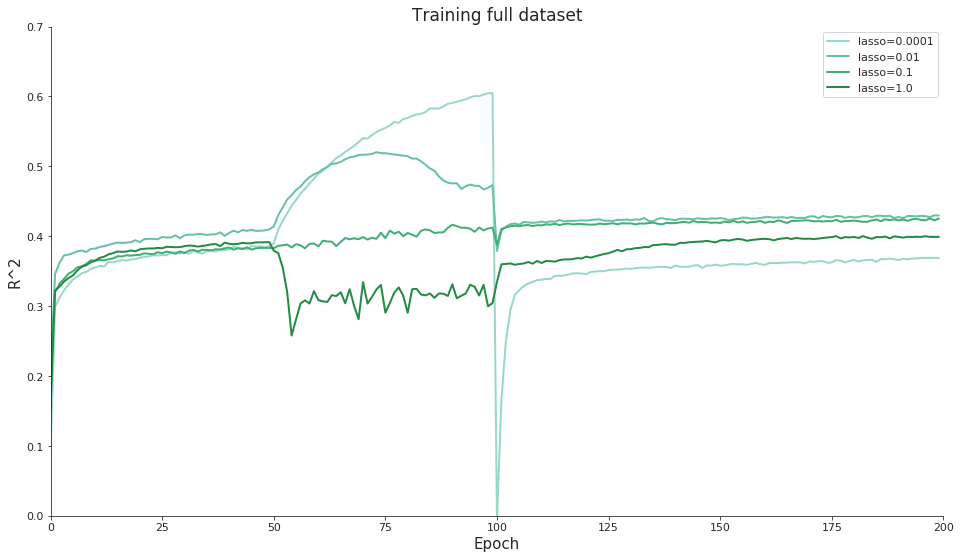

In [125]:
# The learning curves for our favourite model: pre-tr + train last 4 layers only + train all + prune
linewidth = 2
sns_styleset()

epochs_used = 200
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']
for j, l1 in enumerate(l1_params):
    ax.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr_Full_Dataset, axis = (1))[j,:], \
             c = colours[j], linewidth=linewidth, label='lasso={}'.format(l1))
ax.set_ylim([0, 0.7])
ax.set_xlim([0, 200])
ax.set_title('Training full dataset', fontsize = 17)
ax.set_xlabel('Epoch', fontsize = 15)
ax.set_ylabel('R^2', fontsize = 15)
ax.legend(loc='best', fontsize = 11)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)
sns.despine()

plt.savefig('Bottleneck_Learning_Curves_LASSO_Full_Dataset.png', dpi=200)

Let us pick our lasso parameter and see the average over cvfolds 25 biggest L2 norms of the first kernel and so on.

In [67]:
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

In [64]:
weights_before_unfreezing = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/FreezeUnfreeze_before_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format(1000, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_before_unfreezing.append(saved_model.get_weights()[0])
weights_before_unfreezing = np.array(weights_before_unfreezing)

In [68]:
weights_after_unfreezing = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format(1000, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing.append(saved_model.get_weights()[0])
weights_after_unfreezing = np.array(weights_after_unfreezing)

In [235]:
weights_after_unfreezing_ap = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                             format(1000, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing_ap.append(saved_model.get_weights()[0])
weights_after_unfreezing_ap = np.array(weights_after_unfreezing_ap)

In [16]:
weights_after_unfreezing_bootstrapping = []
for f in range(10):
    saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format(2000+f, 0, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing_bootstrapping.append(saved_model.get_weights()[0])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [17]:
counter_0_list=[]
counter_1_list=[]
sRRRrank2genes = np.array(['Bdnf', 'Gad1', 'Lamp5', 'Plch2', 'Gabrd', 'Cacna2d1', 'Elfn1', 'Slc6a1', 'Nxph1', \
 'Tac1', 'Npas1', 'Ndn', 'Arpp21', 'Htr3a', 'Mybpc1', 'Tac2', 'Coro6', 'Nrn1',
 'Synpr', 'Ptk2b', 'Kcnv1', 'Pvalb', 'Sst', 'Galnt14', 'Kcnip2']) # See later on how this is constructed
for f in range(10):
    BNN_genes = geneNames[np.argsort(np.linalg.norm(weights_after_unfreezing_bootstrapping[f], \
                                                 ord=2, axis=1), axis = 0)][-25:]
    if f!=9:
        BNN_genes_next = geneNames[np.argsort(np.linalg.norm(weights_after_unfreezing_bootstrapping[f+1], \
                                                 ord=2, axis=1), axis = 0)][-25:]
    print('\nrun {}: \n'.format(f), BNN_genes)
    print('Found for sRRR rank 2 too: ')
    counter_0=0
    for gene in BNN_genes:
        if gene in sRRRrank2genes:
            print(gene)
            counter_0+=1
    counter_0_list.append(counter_0)
    print('Found in the next run too: ')
    counter_1=0
    for gene in BNN_genes:
        if f!=9:
            if gene in BNN_genes_next:
                print(gene)
                counter_1+=1
    if f!=9:
        counter_1_list.append(counter_1)    


run 0: 
 ['Nell1' 'Mas1' 'Enpp2' 'Gm11549' 'Gabra1' 'Erbb4' 'Ptk2b' 'Pcp4' 'Bdnf'
 'Grm7' 'Gas7' 'Elfn1' 'Cacna2d1' 'Slc6a1' 'Atp1a3' 'Satb1' 'Plch2'
 'Mybpc1' 'Tac2' 'Ndn' 'Htr3a' 'Sst' 'Lamp5' 'Gad1' 'Pvalb']
Found for sRRR rank 2 too: 
Ptk2b
Bdnf
Elfn1
Cacna2d1
Slc6a1
Plch2
Mybpc1
Tac2
Ndn
Htr3a
Sst
Lamp5
Gad1
Pvalb
Found in the next run too: 
Mas1
Enpp2
Gm11549
Gabra1
Pcp4
Grm7
Elfn1
Slc6a1
Atp1a3
Satb1
Plch2
Mybpc1
Tac2
Ndn
Htr3a
Sst
Lamp5
Gad1
Pvalb

run 1: 
 ['Mas1' 'Gabrd' 'Enpp2' 'Mybpc1' 'Gm11549' 'Dusp14' 'Cck' 'Satb1' 'Cplx1'
 'Gabra1' 'Grm7' 'Slc6a1' 'Atp1a3' 'Plch2' 'Kcnip2' 'Galnt14' 'Elfn1'
 'Pcp4' 'Ndn' 'Lamp5' 'Htr3a' 'Gad1' 'Tac2' 'Pvalb' 'Sst']
Found for sRRR rank 2 too: 
Gabrd
Mybpc1
Slc6a1
Plch2
Kcnip2
Galnt14
Elfn1
Ndn
Lamp5
Htr3a
Gad1
Tac2
Pvalb
Sst
Found in the next run too: 
Mybpc1
Satb1
Cplx1
Slc6a1
Atp1a3
Plch2
Lamp5
Gad1
Pvalb

run 2: 
 ['Usp14' 'Gas7' 'Ak5' 'Tac1' 'Ptgs2' 'Flt3' 'Slc6a1' 'Coro6' 'Cplx1'
 'Cacna2d3' 'Plch2' 'Satb1' 'Adcyap1' 'Atp1a3' 'Mybp

In [18]:
BNN_genes_list = []
for f in range(10):
    BNN_genes = geneNames[np.argsort(np.linalg.norm(weights_after_unfreezing_bootstrapping[f], \
                                                 ord=2, axis=1), axis = 0)][-25:]
    BNN_genes_list.append([BNN_genes])
BNN_genes_list = np.reshape(np.array(BNN_genes_list), newshape=25*10)
for gene in np.unique(BNN_genes_list):
    print(gene,  sum(BNN_genes_list==gene))

Adcyap1 1
Ak5 1
Atp1a3 10
Bdnf 3
Cacna2d1 5
Cacna2d3 2
Cck 4
Chat 1
Col24a1 1
Coro6 2
Cplx1 8
Dclk3 1
Dusp14 4
Elfn1 9
Enpp2 5
Erbb4 3
Flt3 1
Fxyd6 1
Gabra1 7
Gabrd 6
Gad1 10
Galnt14 6
Gas7 3
Gm11549 5
Grm7 9
Htr3a 9
Kcnc2 2
Kcnip2 8
Lamp5 10
Mas1 2
Mybpc1 5
Ndn 9
Ndst3 4
Nell1 2
Pcp4 9
Pcp4l1 1
Pde1a 3
Plch2 10
Ptgs2 1
Ptk2b 5
Pvalb 10
Reln 1
Satb1 10
Slc6a1 10
Sparcl1 3
Sst 9
Synpr 1
Tac1 5
Tac2 9
Usp14 1
Vip 3


In [19]:
np.mean(counter_0_list)

14.1

In [20]:
np.mean(counter_1_list)

17.666666666666668

In [33]:
# For our model
sRRRrank2genes = np.array(['Bdnf', 'Gad1', 'Lamp5', 'Plch2', 'Gabrd', 'Cacna2d1', 'Elfn1', 'Slc6a1', 'Nxph1', \
 'Tac1', 'Npas1', 'Ndn', 'Arpp21', 'Htr3a', 'Mybpc1', 'Tac2', 'Coro6', 'Nrn1',
 'Synpr', 'Ptk2b', 'Kcnv1', 'Pvalb', 'Sst', 'Galnt14', 'Kcnip2']) # See later on how this is constructed
BNN_genes = geneNames[np.argsort(np.linalg.norm(weights_after_unfreezing, \
                                             ord=2, axis=2), axis = 1)[2, :]][-25:]
counter_0=0
for gene in BNN_genes:
    if gene in sRRRrank2genes:
        print(gene)
        counter_0+=1

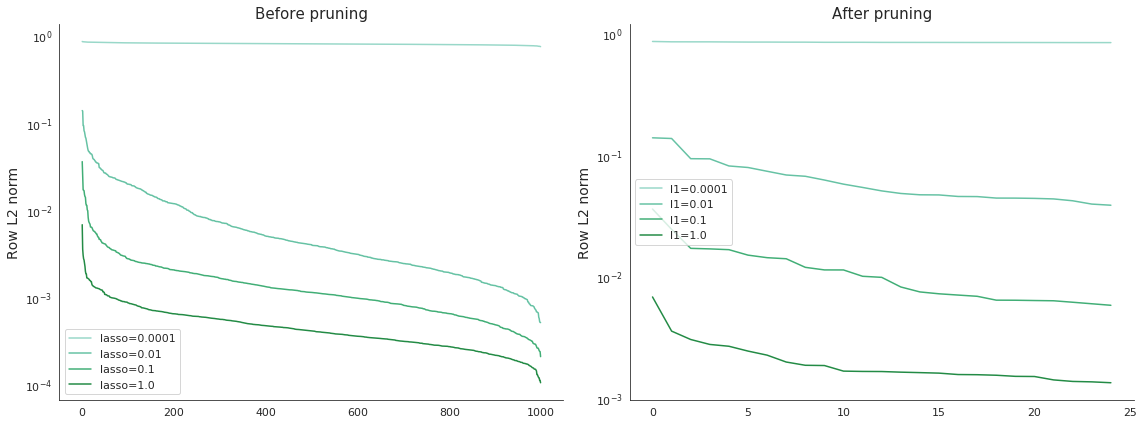

In [237]:
fig = plt.figure(figsize = (16, 6))
ax1 = fig.add_subplot(121)
colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']
for j, l1 in enumerate(l1_params):
    ax1.plot(range(1000), np.sort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[j, ::-1].T, \
             c = colours[j], label = 'lasso={}'.format(l1))
ax1.set_ylabel('Row L2 norm', fontsize = 14)
ax1.set_title('Before pruning', fontsize = 15)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.tick_params(axis='both', which='minor', labelsize=11)
ax1.set_yscale('log')
ax1.legend(loc='best', fontsize=11)

ax2 = fig.add_subplot(122)
for j, l1 in enumerate(l1_params):
    ax2.plot(range(25), np.sort(np.linalg.norm(weights_after_unfreezing_ap, ord=2, axis=2), axis = 1)[j, ::-1].T, \
             c = colours[j], label = 'l1={}'.format(l1))
ax2.set_ylabel('Row L2 norm', fontsize = 14)
ax2.set_title('After pruning', fontsize = 15)
ax2.tick_params(axis='both', which='major', labelsize=11)
ax2.tick_params(axis='both', which='minor', labelsize=11)
ax2.set_yscale('log')
ax2.legend(loc='best', fontsize=11)
sns.despine()

#fig.suptitle('Row L2 norm of the first kernel in the network before and after pruning', y = 1.05, fontsize=18)
plt.tight_layout()

plt.savefig('Bottleneck_lasso_pruning_L2_norms_FULL_DATASET.png', dpi=200)

In [134]:
with open('sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

In [135]:
with open('sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16 = pickle.load(f)

In [136]:
# This should be a pickled file created from the other notebook
with open('Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'rb') as f:
        r2_before_unfreezing, r2_before_unfreezing_tr, \
        r2_after_unfreezing, r2_after_unfreezing_tr, \
        r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
        r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

In [137]:
r2_freeze_unfreeze_hist.shape

(10, 4, 1, 200)

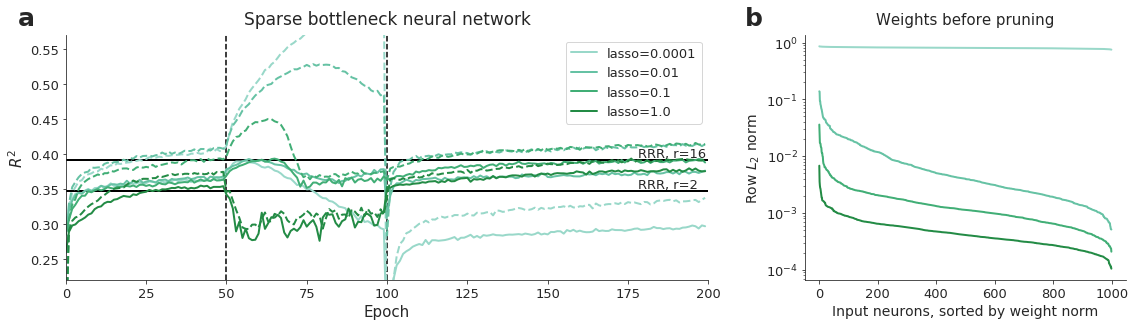

In [142]:
# Everything in one figure for the paper
linewidth = 2
sns_styleset()
epochs_used = 200
colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

fig = plt.figure(figsize=(19, 4.5))
widths = [2, 1]
heights = [1]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                          height_ratios=heights)

ax1 = fig.add_subplot(spec[0, 0])
for j, l1 in enumerate(l1_params):
    ax1.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis = (0, 2))[j, :].T, \
             '--', c = colours[j], linewidth=linewidth)
    ax1.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis = (0, 2))[j, :].T, \
             c = colours[j], linewidth=linewidth, label='lasso={}'.format(l1))
ax1.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax1.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax1.annotate('RRR, r=16', (178, r_rank16_r[np.isclose(n_rank16, 25, atol=3)]+0.004), fontsize=13)
ax1.annotate('RRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=3)]+0.004), fontsize=13)
ax1.set_ylim([0.22, 0.57])
ax1.set_xlim([0, epochs_used])
ax1.set_title('Sparse bottleneck neural network', fontsize = 17, y=1.02)
ax1.set_xlabel('Epoch', fontsize = 15)
ax1.set_ylabel(r'$R^2$', fontsize = 15)
ax1.legend(loc='best', fontsize = 13)
ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.tick_params(axis='both', which='minor', labelsize=13)
ax1.set_xticks(np.arange(0, 225, 25))
ax1.vlines(x=50, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')
ax1.vlines(x=100, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')

ax2 = fig.add_subplot(spec[0, 1])
colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']
for j, l1 in enumerate(l1_params):
    ax2.plot(range(1000), np.sort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[j, ::-1].T, \
             c = colours[j], label = 'lasso={}'.format(l1), linewidth=linewidth)
ax2.set_ylabel(r'Row $L_2$ norm', fontsize = 14)
ax2.set_xlabel('Input neurons, sorted by weight norm', fontsize = 14)
ax2.set_title('Weights before pruning', fontsize = 15, y=1.02)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='minor', labelsize=13)
ax2.set_yscale('log')

plt.text(-0.075, 1.04, 'a', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.185, 1.04, 'b', transform = ax2.transAxes, fontsize=25, fontweight='bold')
sns.despine()

#plt.savefig('Bottleneck_Figure4.png', bbox_inches = 'tight',
#    pad_inches = 0)
plt.savefig('Bottleneck_Figure4.pdf', bbox_inches = 'tight',
    pad_inches = 0)

In [139]:
# Print the genes selected for this lasso, our favourite model 
highest_genes = 25
for j, l1 in enumerate(l1_params):
    print('For lasso: {}'.format(l1), \
          '\nThese {} highest genes were selected: '.format(highest_genes), \
         geneNames[np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[j, ::-1][:highest_genes]])

For lasso: 0.0001 
These 25 highest genes were selected:  ['Osbpl1a' 'Mapk8ip3' 'Strap' 'Sst' 'Magee2' 'Naa60' 'Mmgt1' 'Rab18'
 'St3gal5' 'Coro6' 'Gpr176' 'Aars' 'Adcyap1' 'Pvalb' 'Crispld2' 'Ogt'
 'Zfp871' '2900011O08Rik' 'Egr1' 'Ctsb' 'Zcchc12' 'Peg3' 'Thbs2' 'Pde1a'
 'Trf']
For lasso: 0.01 
These 25 highest genes were selected:  ['Vip' 'Sst' 'Pvalb' 'Coro6' 'Tac2' 'Lamp5' 'Gad1' 'Ndn' 'Thsd7a'
 'Dlx6os1' 'Adarb2' 'Cplx1' 'Mas1' 'Vstm2a' 'Synpr' 'Ndst3' 'Pcdhb10'
 'Htr3a' 'Rph3a' 'Pcp4l1' 'Slc6a1' 'Flt3' 'Prox1' 'Ptk2b' 'Arpp19']
For lasso: 0.1 
These 25 highest genes were selected:  ['Sst' 'Pvalb' 'Ndst3' 'Gad1' 'Coro6' 'Lamp5' 'Tac2' 'Synpr' 'Htr3a' 'Ndn'
 'Cbln2' 'Vip' 'Cplx1' 'Mas1' 'Grm7' 'Thsd7a' 'Atp1a3' 'Fezf2' 'Chat'
 'Bdnf' 'Ptpru' 'Gm11549' 'Ptgs2' 'Trp53i11' 'Flt3']
For lasso: 1.0 
These 25 highest genes were selected:  ['Pvalb' 'Gad1' 'Lamp5' 'Elfn1' 'Sst' 'Ndn' 'Tac2' 'Synpr' 'Cacna2d3'
 'Cacna2d1' 'Dclk3' 'Bdnf' 'AW551984' 'Asns' 'Mybpc1' 'Cyp1b1' 'Fam107b'
 'Pcp4l1' '

In [59]:
lambdas = np.arange(.1,2,.1)

In [60]:
with open('sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

In [61]:
with open('sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16 = pickle.load(f)

In [62]:
# And what are the genes selected for sRRR for the different cross validated sets and the lambdau we'd have to pick?

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

t = time.time()

np.random.seed(seed)
n = X_no_low_qual.shape[0]
X = np.copy(X_no_low_qual)
Y = np.copy(Y_no_low_qual)

X = X.astype('float64')
Y = Y.astype('float64')

vx_rank2, vy_rank2 = sparseRRR.elastic_rrr(X, Y, \
                            lambdau=lambdas[np.isclose(n_rank2, 25, atol=3)], alpha=1, rank=2, sparsity='row-wise')
print('For rank 2, ', \
      '\nThese highest genes were selected: ', \
      geneNames[np.sum(vx_rank2, axis = 1)!=0])
vx_rank16, vy_rank16 = sparseRRR.elastic_rrr(X, Y, \
                            lambdau=lambdas[np.isclose(n_rank16, 25, atol=3)], alpha=1, rank=16, sparsity='row-wise')

print('For rank 16, ', \
      '\nThese highest genes were selected: ', \
      geneNames[np.sum(vx_rank16, axis = 1)!=0])

For rank 2,  
These highest genes were selected:  ['Bdnf' 'Gad1' 'Lamp5' 'Plch2' 'Gabrd' 'Cacna2d1' 'Elfn1' 'Slc6a1' 'Tac1'
 'Npas1' 'Arpp21' 'Htr3a' 'Mybpc1' 'Coro6' 'Nrn1' 'Synpr' 'Ptk2b' 'Kcnv1'
 'Pvalb' 'Sst' 'Kcnip2']
For rank 16,  
These highest genes were selected:  ['Erbb4' 'Bdnf' 'Gad1' 'Lamp5' 'Bcan' 'Plch2' 'Gabrd' 'Cacna2d1' 'Elfn1'
 'Slc6a1' 'Tac1' 'Arpp21' 'Htr3a' 'Mybpc1' 'Vip' 'Coro6' 'Nrn1' 'Synpr'
 'Ptk2b' 'Pvalb' 'Sst' 'Kcnip2']


# Visualisation latent spaces

In [24]:
from tensorflow.keras import backend as K
from scipy.interpolate import SmoothBivariateSpline

Text(0.5, 1.0, 'Latent space')

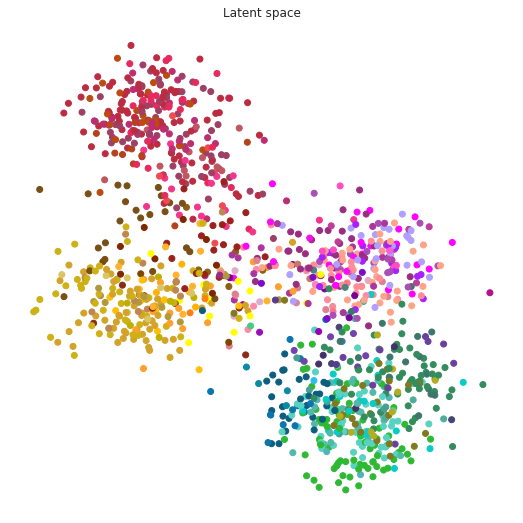

In [103]:
# Before unfreezing
lasso_id=2
saved_model = load_model('KerasSavedModels/FreezeUnfreeze_before_unfreezing_full_dataset_{}_{}_{}.h5'.\
                        format(1000, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
                                  [saved_model.output])
#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
latent = encoder.predict(X_no_low_qual)                 # bottleneck representation

sns.set_style('white')
plt.figure(figsize = (9, 9))
plt.scatter(latent[:, 0], latent[:, 1],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes_no_low_qual])
sns.despine(bottom = True, left = True)
plt.xticks([])
plt.yticks([])
plt.title('Latent space')

R^2 score on all:  0.4172211289405823


Text(0.5, 1.0, 'Latent space')

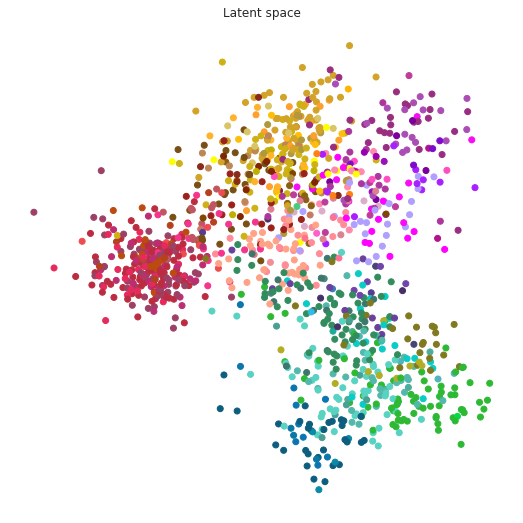

In [233]:
# After unfreezing
lasso_id=2
saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                        format(1000, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
                                  [saved_model.output])
#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
latent = encoder.predict(X_no_low_qual)                 # bottleneck representation
ephys_prediction = saved_model.predict(X_no_low_qual)             # class prediction
print('R^2 score on all: ', 1-np.sum((Y_no_low_qual - saved_model.predict(x=X_no_low_qual))**2) / np.sum(Y_no_low_qual**2))

sns.set_style('white')
plt.figure(figsize = (9, 9))
plt.scatter(latent[:, 0], latent[:, 1],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes_no_low_qual])
sns.despine(bottom = True, left = True)
plt.xticks([])
plt.yticks([])
plt.title('Latent space')

R^2 score on all:  0.29057103395462036


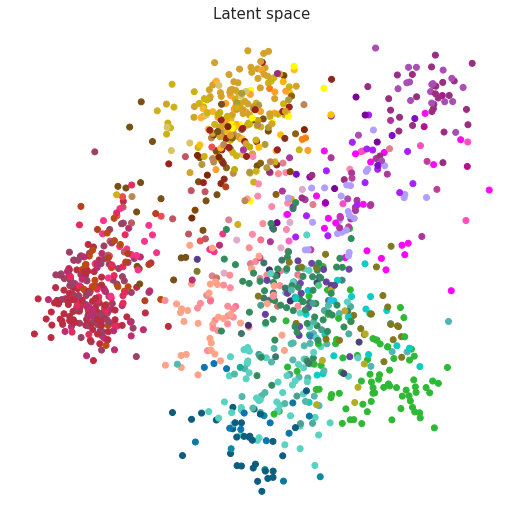

In [147]:
# Pick a NN L2 reg parameter number
lasso_id=2   # a number from 0 to 3 (corresponding to 1e-4, 1e-2, 1e-1, 1 lasso penalty respectively)



saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format(1000, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
                                  [saved_model.output])
#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
latent = encoder.predict(X_no_low_qual[:, ind_genes])                 # bottleneck representation
ephys_prediction = saved_model.predict(X_no_low_qual[:, ind_genes])             # class prediction
print('R^2 score on all: ', 1-np.sum((Y_no_low_qual - \
                                      saved_model.predict(x=X_no_low_qual[:, ind_genes]))**2) / np.sum(Y_no_low_qual**2))

sns.set_style('white')
plt.figure(figsize = (9, 9))
plt.scatter(latent[:, 0], latent[:, 1],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes_no_low_qual])
sns.despine(bottom = True, left = True)
plt.xticks([])
plt.yticks([])
plt.title('Latent space', fontsize=15)
plt.savefig('Bottleneck_latent.png', bbox_inches = 'tight',
    pad_inches = 0)

In [1]:
# sns.set_style('white')
# plt.figure(figsize = (9, 9))
# x = np.linspace(np.min(latent[:, 0]), np.max(latent[:, 0]), 40)
# y = np.linspace(np.min(latent[:, 1]), np.max(latent[:, 1]), 40)
# xv, yv = np.meshgrid(x, y)
# grid = np.empty((xv.shape[0], xv.shape[1]))

# for i in range(grid.shape[0]):
#     for j in range(grid.shape[1]):
#         #print(xv[i, j], yv[i, j])
#         grid[i, j] = ephys_prediction_from_bottleneck(np.array([xv[i, j], yv[i, j]])[np.newaxis, :])[0][0, 14]
# plt.contourf(x, y, grid, alpha = 1)
# plt.scatter(latent[:, 0], latent[:, 1],
#             c = ephys_prediction[:, 14])

# #plt.scatter(latent[:, 0], latent[:, 1],
# #            c = ephys_prediction_from_bottleneck(latent[:, 0], latent[:, 1])[:, 14])

# #colour = np.zeros_like((latent[:, 0]))
# #for i in range(latent.shape[0]):
# #    colour[i] = ephys_prediction_from_bottleneck(latent[i,:][np.newaxis, :])[0][0, 14]
# #plt.scatter(latent[:, 0], latent[:, 1],
# #            c = ephys_prediction_from_bottleneck(encoder.predict(X_no_low_qual[:, ind_genes]))[0][:, 14])

# #plt.scatter(latent[:, 0], latent[:, 1],
# #            c = colour)

# sns.despine(bottom = True, left = True)
# plt.xticks([])
# plt.yticks([])
# #plt.xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
# #plt.ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
# plt.title('Latent space')
# #plt.savefig('LatentSpace.png')

In [110]:
# sns.set_style('white')
# plt.figure(figsize = (9, 9))
# x = np.linspace(np.min(latent[:, 0]), np.max(latent[:, 0]), 40)
# y = np.linspace(np.min(latent[:, 1]), np.max(latent[:, 1]), 40)
# xv, yv = np.meshgrid(x, y)
# grid = np.empty((xv.shape[0], xv.shape[1]))

# for i in range(grid.shape[0]):
#     for j in range(grid.shape[1]):
#         #print(xv[i, j], yv[i, j])
#         grid[i, j] = ephys_prediction_from_bottleneck(np.array([xv[i, j], yv[i, j]])[np.newaxis, :])[0][0, 14]
# plt.contourf(x, y, grid, alpha = 1)
# plt.scatter(xv, yv, c = grid)
# sns.despine(bottom = True, left = True)
# plt.xticks([])
# plt.yticks([])
# #plt.xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
# #plt.ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
# plt.title('Latent space')
# plt.savefig('LatentSpace.png')

In [111]:
# sns_styleset()
# plt.figure(figsize = (9, 9))
# plt.tricontourf(latent[:, 0], latent[:, 1], ephys_prediction_from_bottleneck(latent)[0][:, 14])
# #plt.scatter(latent[:, 0], latent[:, 1],
# #            c = ephys_prediction[:, 14])

# plt.scatter(latent[:, 0], latent[:, 1],
#             c = ephys_prediction_from_bottleneck(latent)[0][:, 14])
# sns.despine(bottom = True, left = True)
# plt.xticks([])
# plt.yticks([])
# #plt.xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
# #plt.ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
# plt.title('Latent space')
# plt.savefig('LatentSpace.png')

In [112]:
# sns.set_style('white')
# plt.figure(figsize = (9, 9))
# saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.format(1000, 1, 0), \
#                         custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# # Retrieve activations and ephys prediction
# encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
# ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[1, :][-25:]
# latent = encoder.predict(X_no_low_qual[:, ind_genes])                 # bottleneck representation

# f = SmoothBivariateSpline(latent[:, 0], latent[:, 1], X_no_low_qual[:, ind_genes][:, -3])
# plt.tricontourf(latent[:,0], latent[:,1], f.ev(latent[:, 0], latent[:,1]))
# plt.scatter(latent[:,0], latent[:,1],
#             c = X_no_low_qual[:, ind_genes][:, -3])
# sns.despine(bottom = True, left = True)
# plt.xticks([])
# plt.yticks([])
# #plt.xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
# #plt.ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
# plt.title('Latent space')
# plt.savefig('LatentSpace.png')

In [113]:
# sns.set_style('white')
# plt.figure(figsize = (9, 9))
# plt.scatter(latent[:, 0], latent[:, 1],
#             c = Y_no_low_qual[:, 14], s=20)
# sns.despine(bottom = True, left = True)
# plt.xticks([])
# plt.yticks([])
# #plt.xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
# #plt.ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
# plt.title('Latent space')
# #plt.savefig('LatentSpace.png')

In [114]:
# def contour(model, X, Y, Y_column_index, features, celltypes, cellTypeLabels, cellTypeColors, alpha = 0.5, axes = None):
#     ''' Returns a first latent space of the neural network defined by the keras model coloured by celltype. Returns a
#     second latent space with predicted ephys feature contours and data points coloured by this predicted ephys feature.
#     A third latent space is also provided with the same contours
#     but this time data points are coloured by truth ephys feature values. The ephys feature corresponds to a callableolumn in
#     Y provided by Y_column_index.
    
#     Parameters
#     ---------
#     model: keras deep bottleneck neural network regression model
#     X: 2D numpy array, normalized transcriptomic data
#     Y: 2D numpy array, normalized ephys data
#     Y_column_index: column index in Y, correspoding to certain feature
#     features: list of all ephys features (Y_column_index should correspond to correct feature in this list!)
#     celltypes: 1D numpy array, same size as first dimension of X and Y, numbers denote celltype/cellclass
#     celltypeLabels: dictionary with celltype numbers corresponding to celltype names
#     celltypeColors: dictionary with celltype names corresponding to celltype colours
#     alpha: transparancy for contours (default = 0.5)
#     axes: axes to plot one (default: None)
    
#     Returns
#     ---------
#     axes: figure objects; two subplots corresponding to predicted and truth colour coding of data points with
#           same predicted contours
#     '''
#     # Create mappings from the model to get latent activations from genes and ephys predictions from genes and
#     # latent activations
#     encoder = Model(model.input, model.get_layer('bottleneck').output)
#     latent = encoder.predict(X)                           # bottleneck representation
#     ephys_prediction = saved_model.predict(X)             # class prediction
#     ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output], [saved_model.output])
    
#     # Create a grid in the latent space. For every coordinate/every latent space activation sequence, check its predicted
#     # ephys feature
#     x = np.linspace(np.min(latent[:, 0]), np.max(latent[:, 0]), 20)
#     y = np.linspace(np.min(latent[:, 1]), np.max(latent[:, 1]), 20)
#     xv, yv = np.meshgrid(x, y)
#     grid = np.empty((xv.shape[0], xv.shape[1]))
#     for i in range(grid.shape[0]):
#         for j in range(grid.shape[1]):
#             grid[i, j] = ephys_prediction_from_bottleneck(np.array([xv[i, j], yv[i, j]])[np.newaxis, :])[0][0, Y_column_index]
    
#     # Create figure
#     if axes:
#         axes = axes
#     else:
#         fig, axes = plt.subplots(nrows=1,ncols=3, figsize = (16, 6))
#     axes[0].scatter(latent[:, 0], latent[:, 1], c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in celltypes])
#     axes[1].contourf(x,y,grid, alpha=alpha)
#     axes[1].scatter(latent[:, 0], latent[:, 1], c = ephys_prediction[:, Y_column_index])
#     axes[2].contourf(x,y,grid, alpha=alpha)
#     axes[2].scatter(latent[:, 0], latent[:, 1], c = Y_no_low_qual[:, Y_column_index])
#                     #c = X[:, 6])

#     for ax in axes:
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_xticklabels('')
#         ax.set_yticklabels('')
#     sns.despine(bottom=True, left=True)
#     fig.suptitle(features[Y_column_index], fontsize = 20)
#     plt.tight_layout()
#     return axes

In [115]:
# saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.format(1000, 1, 0), \
#                         custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})
# ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[1, :][-25:]
# for i in range(Y_no_low_qual.shape[1]):
#     #fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (16, 6))
#     contour(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#             i, M1_ephys.columns, cellTypes_no_low_qual, cellTypeLabels, \
#             cellTypeColors)
#     plt.savefig('LatentSpaceContours/LatentSpaceContoursFor_{}'.format(M1_ephys.columns[i]), dpi=200)

In [116]:
# for i, feature in enumerate(list(M1_ephys.columns)):
#     plt.figure()
#     plt.scatter(Y_no_low_qual[:, i], ephys_prediction[:, i])
#     plt.xlabel('True')
#     plt.ylabel('Predicted')
#     plt.title(feature)
#     plt.savefig('Correlations/{}'.format(feature))

In [96]:
def latent_space_ephys(model, X, Y, Y_column_index, features, celltypes, cellTypeLabels, \
                       cellTypeColors, alpha = 1, axis = None):
    '''
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    Y: 2D numpy array, normalized ephys data
    Y_column_index: column index in Y, correspoding to certain feature
    features: list of all ephys features (Y_column_index should correspond to correct feature in this list!)
    celltypes: 1D numpy array, same size as first dimension of X and Y, numbers denote celltype/cellclass
    celltypeLabels: dictionary with celltype numbers corresponding to celltype names
    celltypeColors: dictionary with celltype names corresponding to celltype colours
    alpha: transparancy for contours (default = 0.5)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure objects; latent space with gene activation contours
    '''
    # Create mappings from the model to get latent activations from genes and ephys predictions from genes and
    # latent activations
    encoder = Model(model.input, model.get_layer('bottleneck').output)
    latent = encoder.predict(X)                           # bottleneck representation
    ephys_prediction = saved_model.predict(X)             # class prediction
    ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output], [saved_model.output])
    
#     # Create a grid in the latent space. For every coordinate/every latent space activation sequence, check its predicted
#     # ephys feature
#     x = np.linspace(np.min(latent[:, 0]-0.2), np.max(latent[:, 0])+0.2, 20)
#     y = np.linspace(np.min(latent[:, 1]-0.2), np.max(latent[:, 1])+0.2, 20)
#     xv, yv = np.meshgrid(x, y)
#     grid = np.empty((xv.shape[0], xv.shape[1]))
#     for i in range(grid.shape[0]):
#         for j in range(grid.shape[1]):
#             grid[i, j] = ephys_prediction_from_bottleneck(np.array([xv[i, j], yv[i, j]])[np.newaxis, :])[0][0, Y_column_index]
    
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    
    ax.tricontourf(latent[:, 0], latent[:, 1], ephys_prediction[:, Y_column_index])
    #ax.scatter(latent[:, 0], latent[:, 1], c = ephys_prediction[:, Y_column_index])
    ax.set_xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
    ax.set_ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(features[Y_column_index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

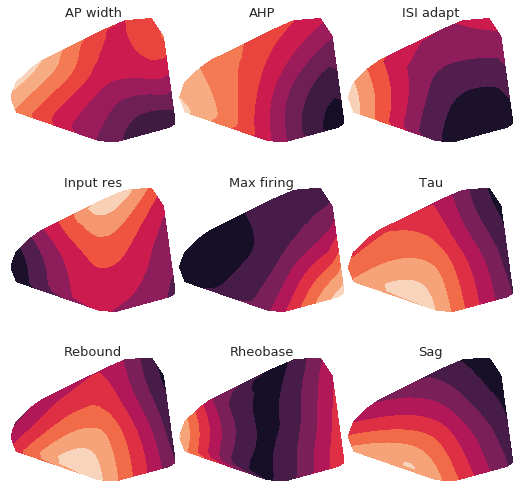

In [91]:
lasso_id=2
fig = plt.figure(figsize=(9, 9))
widths = [1,1,1]
heights = [1,1,1]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights)

saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format(1000, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[1, :][-25:]
features = ['AP amp', 'AP amp adapt', 'AP amp CV', 'AP thresh', 'AP width', 'AHP', \
            'ISI adapt', 'ISI CV', 'Input res', 'Max firing', 'Tau', \
            'Rebound', r'$V_m$', 'Rheobase', 'Sag', 'UDR']
spec.update(wspace=0.025, hspace=0.13)

# Use the index of the feature that you want to see as input integer in the latent_space function
ax1 = fig.add_subplot(spec[0, 0])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        4, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax1)
ax2 = fig.add_subplot(spec[0, 1])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        5, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax2)
ax3 = fig.add_subplot(spec[0, 2])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        6, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax3)
ax4 = fig.add_subplot(spec[1, 0])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        8, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax4)
ax5 = fig.add_subplot(spec[1, 1])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        9, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax5)
ax6 = fig.add_subplot(spec[1, 2])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        10, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax6)
ax7 = fig.add_subplot(spec[2, 0])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        11, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax7)
ax8 = fig.add_subplot(spec[2, 1])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        13, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax8)
ax9 = fig.add_subplot(spec[2, 2])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        14, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax9)
#plt.tight_layout()
sns.despine(bottom=True, left=True)
plt.savefig('Bottleneck_latent_ephys.png', bbox_inches = 'tight',
    pad_inches = 0)

In [22]:
def latent_space_genes(model, X, X_column_index, geneNames, celltypes, cellTypeLabels, \
                       cellTypeColors, alpha = 0.5, axis = None):
    ''' 
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    X_column_index: column index in X, correspoding to certain gene
    geneNames: list of gene names (X_column_index should correspond to correct gene in this list!)
    celltypes: 1D numpy array, same size as first dimension of X and Y, numbers denote celltype/cellclass
    celltypeLabels: dictionary with celltype numbers corresponding to celltype names
    celltypeColors: dictionary with celltype names corresponding to celltype colours
    alpha: transparancy for contours (default = 0.5)
    ax: axis to plot one (default: None)
    
    Returns
    -------
    axis: figure objects; latent space with gene activation contours
    '''
    # Create mappings from the model to get latent activations from genes and ephys predictions from genes and
    # latent activations
    encoder = Model(model.input, model.get_layer('bottleneck').output)
    latent = encoder.predict(X)                           # bottleneck representation
    ephys_prediction = saved_model.predict(X)             # class prediction
    ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output], [saved_model.output])
    

    
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
        
        
    # Retrieve latent space activations
    encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
    latent = encoder.predict(X)                 # bottleneck representation

    f = SmoothBivariateSpline(latent[:, 0], latent[:, 1], X[:, X_column_index])
    ax.tricontourf(latent[:,0], latent[:,1], f.ev(latent[:, 0], latent[:,1]))
    ax.set_xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
    ax.set_ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
    #ax.scatter(latent[:,0], latent[:,1],
    #            c = X[:, X_column_index])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(geneNames[ind_genes][X_column_index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

R^2 score on all:  0.29057103395462036


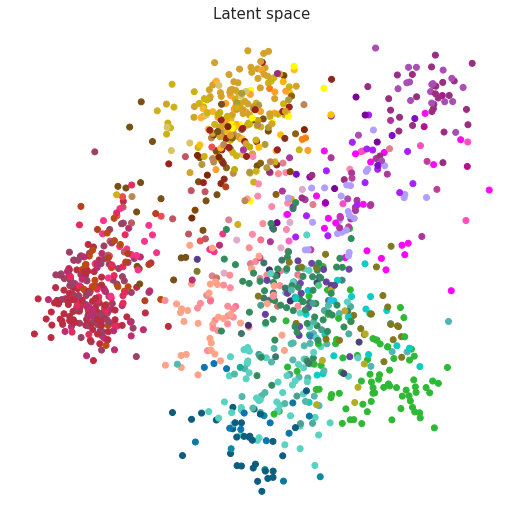

In [232]:
# Pick a NN L2 reg parameter number
lasso_id=2   # a number from 0 to 3 (corresponding to 1e-4, 1e-2, 1e-1, 1 lasso penalty respectively)



saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format(1000, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
                                  [saved_model.output])
#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
latent = encoder.predict(X_no_low_qual[:, ind_genes])                 # bottleneck representation
ephys_prediction = saved_model.predict(X_no_low_qual[:, ind_genes])             # class prediction
print('R^2 score on all: ', 1-np.sum((Y_no_low_qual - \
                                      saved_model.predict(x=X_no_low_qual[:, ind_genes]))**2) / np.sum(Y_no_low_qual**2))

sns.set_style('white')
plt.figure(figsize = (9, 9))
plt.scatter(latent[:, 0], latent[:, 1],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes_no_low_qual])
sns.despine(bottom = True, left = True)
plt.xticks([])
plt.yticks([])
plt.title('Latent space', fontsize=15)
plt.savefig('Bottleneck_latent.png', bbox_inches = 'tight',
    pad_inches = 0)

In [239]:
ind_genes

array([284,  81,  43, 171, 228,  85, 804, 801, 383, 286, 290, 906, 255,
       617, 977, 402, 502, 793, 648, 123, 699, 109, 159, 850, 890])

In [26]:
geneNames[ind_genes][::1]

array(['Flt3', 'Trp53i11', 'Ptgs2', 'Gm11549', 'Ptpru', 'Bdnf', 'Chat',
       'Fezf2', 'Atp1a3', 'Thsd7a', 'Grm7', 'Mas1', 'Cplx1', 'Vip',
       'Cbln2', 'Ndn', 'Htr3a', 'Synpr', 'Tac2', 'Lamp5', 'Coro6', 'Gad1',
       'Ndst3', 'Pvalb', 'Sst'], dtype='<U13')

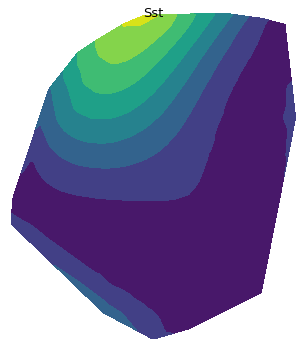

In [25]:
# Test
lasso_id=2
saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format(1000, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
#for i in range(X_no_low_qual[:, ind_genes].shape[1])[0:1]:
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -1, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors)
sns.despine(bottom = True, left = True)
    #plt.savefig('LatentSpaceContours/LatentSpaceContoursFor_{}'.format(geneNames[i]), dpi=200)

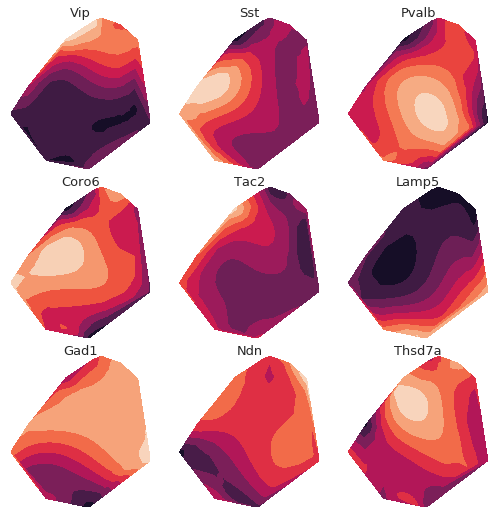

In [231]:
lasso_id=2
fig = plt.figure(figsize=(9, 9))
widths = [1,1,1]
heights = [1,1,1]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights)

saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format(1000, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[1, :][-25:]
features = ['AP amp', 'AP amp adapt', 'AP amp CV', 'AP thresh', 'AP width', 'AHP', \
            'ISI adaptation', 'ISI CV', 'Input resistance', 'Max firing rate', 'Tau', \
            'Rebound', r'$V_m$', 'Rheobase', 'Sag', 'UDR']
spec.update(wspace=0.025, hspace=0.12)

# Use the index of the feature that you want to see as input integer in the latent_space function
ax1 = fig.add_subplot(spec[0, 0])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], 
        -1, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax1)
ax2 = fig.add_subplot(spec[0, 1])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes],\
        -2, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax2)
ax3 = fig.add_subplot(spec[0, 2])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -3, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax3)
ax4 = fig.add_subplot(spec[1, 0])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes],  \
        -4, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax4)
ax5 = fig.add_subplot(spec[1, 1])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -5, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax5)
ax6 = fig.add_subplot(spec[1, 2])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -6, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax6)
ax7 = fig.add_subplot(spec[2, 0])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -7, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax7)
ax8 = fig.add_subplot(spec[2, 1])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -8, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax8)
ax9 = fig.add_subplot(spec[2, 2])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -9, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax9)
#plt.tight_layout()
sns.despine(bottom=True, left=True)
plt.savefig('Bottleneck_latent_genes.png', bbox_inches = 'tight',
    pad_inches = 0)

In [43]:
# # All in one, for the paper

# lasso_id=2
# fig = plt.figure(figsize=(16, 5.2))
# widths = [3,1,1,1,1,1,1]
# heights = [1,1,1]
# spec = fig.add_gridspec(ncols=7, nrows=3, width_ratios=widths,
#                           height_ratios=heights)
# spec.update(wspace=0, hspace=0.12)

# saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
#                         format(1000, lasso_id, 0), \
#                         custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# # Retrieve activations and ephys prediction
# encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
# ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
#                                   [saved_model.output])
# #layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
# ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[1, :][-25:]
# latent = encoder.predict(X_no_low_qual[:, ind_genes])                 # bottleneck representation
# ephys_prediction = saved_model.predict(X_no_low_qual[:, ind_genes])             # class prediction

# # Cell types
# ax0 = fig.add_subplot(spec[:, 0])
# ax0.scatter(latent[:, 0], latent[:, 1],
#             c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes_no_low_qual], s=20)
# ax0.set_aspect('equal', adjustable='box')
# ax0.set_title('sBNN latent space', fontsize=13, y=0.99)
# ax0.set_xticks([])
# ax0.set_yticks([])

# # ephys
# features = ['AP amp', 'AP amp adapt', 'AP amp CV', 'AP thresh', 'AP width', 'AHP', \
#             'ISI adapt', 'ISI CV', 'Input res', 'Max firing', 'Tau', \
#             'Rebound', r'$V_m$', 'Rheobase', 'Sag', 'UDR']
# ax1 = fig.add_subplot(spec[0, 1])
# latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#         4, features, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax1)
# ax2 = fig.add_subplot(spec[0, 2])
# latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#         5, features, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax2)
# ax3 = fig.add_subplot(spec[0, 3])
# latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#         6, features, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax3)
# ax4 = fig.add_subplot(spec[1, 1])
# latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#         8, features, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax4)
# ax5 = fig.add_subplot(spec[1, 2])
# latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#         9, features, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax5)
# ax6 = fig.add_subplot(spec[1, 3])
# latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#         10, features, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax6)
# ax7 = fig.add_subplot(spec[2, 1])
# latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#         11, features, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax7)
# ax8 = fig.add_subplot(spec[2, 2])
# latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#         13, features, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax8)
# ax9 = fig.add_subplot(spec[2, 3])
# latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#         14, features, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax9)

# # genes
# ax10 = fig.add_subplot(spec[0, 4])
# latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], 
#         -1, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax10)
# ax11 = fig.add_subplot(spec[0, 5])
# latent_space_genes(saved_model, X_no_low_qual[:, ind_genes],\
#         -2, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax11)
# ax12 = fig.add_subplot(spec[0, 6])
# latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
#         -3, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax12)
# ax13 = fig.add_subplot(spec[1, 4])
# latent_space_genes(saved_model, X_no_low_qual[:, ind_genes],  \
#         -4, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax13)
# ax14= fig.add_subplot(spec[1, 5])
# latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
#         -5, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax14)
# ax15 = fig.add_subplot(spec[1, 6])
# latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
#         -6, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax15)
# ax16 = fig.add_subplot(spec[2, 4])
# latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
#         -7, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax16)
# ax17 = fig.add_subplot(spec[2, 5])
# latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
#         -8, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax17)
# ax18 = fig.add_subplot(spec[2, 6])
# latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
#         -9, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax18)
# #plt.tight_layout()
# sns.despine(bottom=True, left=True)
# plt.text(-0.01, 1.00, 'a', transform = ax0.transAxes, fontsize=25, fontweight='bold')
# plt.text(-0.09, 1.04, 'b', transform = ax1.transAxes, fontsize=25, fontweight='bold')
# plt.text(-0.09, 1.04, 'c', transform = ax10.transAxes, fontsize=25, fontweight='bold')
# plt.savefig('Bottleneck_latent_space_all_together.png', bbox_inches = 'tight',
#     pad_inches = 0)
# #plt.savefig('Bottleneck_latent_space_all_together.pdf', bbox_inches = 'tight',
# #    pad_inches = 0)

/usr/local/lib/python3.6/dist-packages/matplotlib/gridspec.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


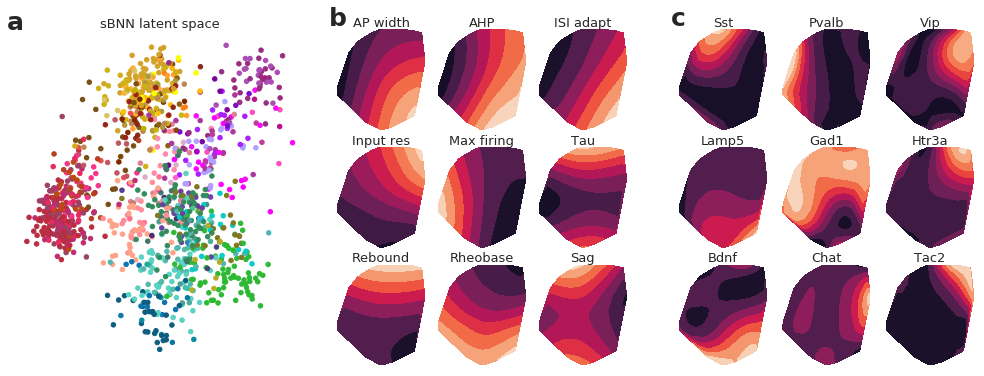

In [188]:
# All in one, for the paper
lasso_id=2
fig = plt.figure(figsize=(16, 5.2))
widths = [2.4,1,1,1]
heights = [1,1,1]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths,
                          height_ratios=heights)
spec.update(wspace=0, hspace=0.12)

saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format(1000, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
                                  [saved_model.output])
#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
latent = encoder.predict(X_no_low_qual[:, ind_genes])                 # bottleneck representation
ephys_prediction = saved_model.predict(X_no_low_qual[:, ind_genes])             # class prediction

# Cell types
ax0 = fig.add_subplot(spec[:, 0])
ax0.scatter(latent[:, 0], latent[:, 1],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes_no_low_qual], s=20)
ax0.set_aspect('equal', adjustable='box')
ax0.set_title('sBNN latent space', fontsize=13, y=0.99)
ax0.set_xticks([])
ax0.set_yticks([])

# ephys
features = ['AP amp', 'AP amp adapt', 'AP amp CV', 'AP thresh', 'AP width', 'AHP', \
            'ISI adapt', 'ISI CV', 'Input res', 'Max firing', 'Tau', \
            'Rebound', r'$V_m$', 'Rheobase', 'Sag', 'UDR']
ax1 = fig.add_subplot(spec[0, 1])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        4, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax1)
ax2 = fig.add_subplot(spec[0, 2])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        5, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax2)
ax3 = fig.add_subplot(spec[0, 3])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        6, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax3)
ax4 = fig.add_subplot(spec[1, 1])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        8, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax4)
ax5 = fig.add_subplot(spec[1, 2])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        9, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax5)
ax6 = fig.add_subplot(spec[1, 3])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        10, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax6)
ax7 = fig.add_subplot(spec[2, 1])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        11, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax7)
ax8 = fig.add_subplot(spec[2, 2])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        13, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax8)
ax9 = fig.add_subplot(spec[2, 3])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        14, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax9)

spec.tight_layout(fig, rect=[0, 0, 0.64, 1], h_pad=0)

widths = [1,1,1]
heights = [1,1,1]
spec2 = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights)
spec2.update(wspace=0, hspace=0.12)
# genes
# -1, -2, -12, -6, -4, -9, -20, -19, -7
ax10 = fig.add_subplot(spec2[0, 0])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], 
        -1, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax10)
ax11 = fig.add_subplot(spec2[0, 1])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes],\
        -2, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax11)
ax12 = fig.add_subplot(spec2[0, 2])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -12, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax12)
ax13 = fig.add_subplot(spec2[1, 0])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes],  \
        -6, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax13)
ax14= fig.add_subplot(spec2[1, 1])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -4, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax14)
ax15 = fig.add_subplot(spec2[1, 2])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -9, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax15)
ax16 = fig.add_subplot(spec2[2, 0])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -20, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax16)
ax17 = fig.add_subplot(spec2[2, 1])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -19, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax17)
ax18 = fig.add_subplot(spec2[2, 2])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -7, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax18)
spec2.tight_layout(fig, rect=[0.535, 0, 1, 1], h_pad=0)
#plt.tight_layout()
sns.despine(bottom=True, left=True)
plt.text(-0.02, 1.00, 'a', transform = ax0.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.09, 1.04, 'b', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.09, 1.04, 'c', transform = ax10.transAxes, fontsize=25, fontweight='bold')
plt.savefig('Bottleneck_latent_space_all_together.png', bbox_inches = 'tight',
    pad_inches = 0)
plt.savefig('Bottleneck_latent_space_all_together.pdf', bbox_inches = 'tight',
    pad_inches = 0)

In [62]:
# And what are the genes selected for sRRR for the different cross validated sets and the lambdau we'd have to pick?

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

t = time.time()
n = X_no_low_qual.shape[0]
X = np.copy(X_no_low_qual)
Y = np.copy(Y_no_low_qual)

X = X.astype('float64')
Y = Y.astype('float64')

vx_rank2, vy_rank2 = sparseRRR.elastic_rrr(X, Y, \
                            lambdau=lambdas[np.isclose(n_rank2, 25, atol=3)], alpha=1, rank=2, sparsity='row-wise')
print('For rank 2, ', \
      '\nThese highest genes were selected: ', \
      geneNames[np.sum(vx_rank2, axis = 1)!=0])
vx_rank16, vy_rank16 = sparseRRR.elastic_rrr(X, Y, \
                            lambdau=lambdas[np.isclose(n_rank16, 25, atol=3)], alpha=1, rank=16, sparsity='row-wise')

print('For rank 16, ', \
      '\nThese highest genes were selected: ', \
      geneNames[np.sum(vx_rank16, axis = 1)!=0])

For rank 2,  
These highest genes were selected:  ['Bdnf' 'Gad1' 'Lamp5' 'Plch2' 'Gabrd' 'Cacna2d1' 'Elfn1' 'Slc6a1' 'Tac1'
 'Npas1' 'Arpp21' 'Htr3a' 'Mybpc1' 'Coro6' 'Nrn1' 'Synpr' 'Ptk2b' 'Kcnv1'
 'Pvalb' 'Sst' 'Kcnip2']
For rank 16,  
These highest genes were selected:  ['Erbb4' 'Bdnf' 'Gad1' 'Lamp5' 'Bcan' 'Plch2' 'Gabrd' 'Cacna2d1' 'Elfn1'
 'Slc6a1' 'Tac1' 'Arpp21' 'Htr3a' 'Mybpc1' 'Vip' 'Coro6' 'Nrn1' 'Synpr'
 'Ptk2b' 'Pvalb' 'Sst' 'Kcnip2']


In [148]:
lambdas[np.isclose(n_rank2, 25, atol=3)]

array([0.4])

In [185]:
# Let us make sure to select exactly 25 genes now.
X = np.copy(X_no_low_qual)
Y = np.copy(Y_no_low_qual)
X = X.astype('float64')
Y = Y.astype('float64')
vx_rank2, vy_rank2 = sparseRRR.elastic_rrr(X, Y, \
                            lambdau=0.34, alpha=1, rank=2, sparsity='row-wise')
print('For rank 2, ', \
      '\nThese highest genes were selected: ', \
      geneNames[np.sum(vx_rank2, axis = 1)!=0])
print('# of genes: ', np.sum(np.sum(vx_rank2, axis = 1)!=0))
# We want to select Sst, Pvalb, Vip, Lamp5, Gad1, Htr3a, Bdnf, Chat, Tac2, are they here in this run?
# 22, 21, 14, 2, 1, 13, 0, 5, 9

For rank 2,  
These highest genes were selected:  ['Bdnf' 'Gad1' 'Lamp5' 'Plch2' 'Gabrd' 'Cacna2d1' 'Elfn1' 'Slc6a1' 'Nxph1'
 'Tac1' 'Npas1' 'Ndn' 'Arpp21' 'Htr3a' 'Mybpc1' 'Tac2' 'Coro6' 'Nrn1'
 'Synpr' 'Ptk2b' 'Kcnv1' 'Pvalb' 'Sst' 'Galnt14' 'Kcnip2']
# of genes:  25


In [219]:
def latent_space_ephys_sRRR(X, vx, vy, Y_column_index, features, celltypes, cellTypeLabels, \
                       cellTypeColors, alpha = 1, axis = None):

    '''
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    vx: matrix to (linearly) project to botteneck
    vy: matrix to (linearly) project from bottleneck to ephys space
    Y_column_index: column index in Y, correspoding to certain feature
    features: list of all ephys features (Y_column_index should correspond to correct feature in this list!)
    celltypes: 1D numpy array, same size as first dimension of X and Y, numbers denote celltype/cellclass
    celltypeLabels: dictionary with celltype numbers corresponding to celltype names
    celltypeColors: dictionary with celltype names corresponding to celltype colours
    alpha: transparancy for contours (default = 0.5)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure object, latent space with ephys activation contours
    '''
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    
    ax.tricontourf((X@vx)[:, 1], (X@vx)[:, 0], (X@vx@vy.T)[:, Y_column_index])
    #ax.scatter((X@vx)[:, 0], (X@vx)[:, 1], c = (X@vx@vy.T)[:, Y_column_index])
    ax.set_xlim([np.min((X@vx)[:, 1]), np.max((X@vx)[:, 1])])
    ax.set_ylim([np.min((X@vx)[:, 0]), np.max((X@vx)[:, 0])])
    #ax.set_xlim([-2, 5])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(features[Y_column_index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [252]:
def latent_space_genes_sRRR(X, vx, index, geneNames, celltypes, cellTypeLabels, \
                       cellTypeColors, alpha = 0.5, axis = None):
    ''' 
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    vx: matrix to (linearly) project to botteneck
    vy: matrix to (linearly) project from bottleneck to ephys space
    index: index in the 25 genes selected for the gene that you'd like to show
    geneNames: list of gene names (X_column_index should correspond to correct gene in this list!)
    celltypes: 1D numpy array, same size as first dimension of X and Y, numbers denote celltype/cellclass
    celltypeLabels: dictionary with celltype numbers corresponding to celltype names
    celltypeColors: dictionary with celltype names corresponding to celltype colours
    alpha: transparancy for contours (default = 0.5)
    ax: axis to plot one (default: None)
    
    Returns
    -------
    axis: figure objects; latent space with gene activation contours
    '''
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))

    f = SmoothBivariateSpline((X@vx)[:, 1], (X@vx)[:, 0], X[:, np.sum(vx, axis = 1)!=0][:, index])
    ax.tricontourf((X@vx)[:,1], (X@vx)[:,0], f.ev((X@vx)[:, 1], (X@vx)[:,0]))
    ax.set_xlim([np.min((X@vx)[:, 1]), np.max((X@vx)[:, 1])])
    ax.set_ylim([np.min((X@vx)[:, 0]), np.max((X@vx)[:, 0])])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(geneNames[np.sum(vx, axis = 1)!=0][index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

/usr/local/lib/python3.6/dist-packages/matplotlib/gridspec.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


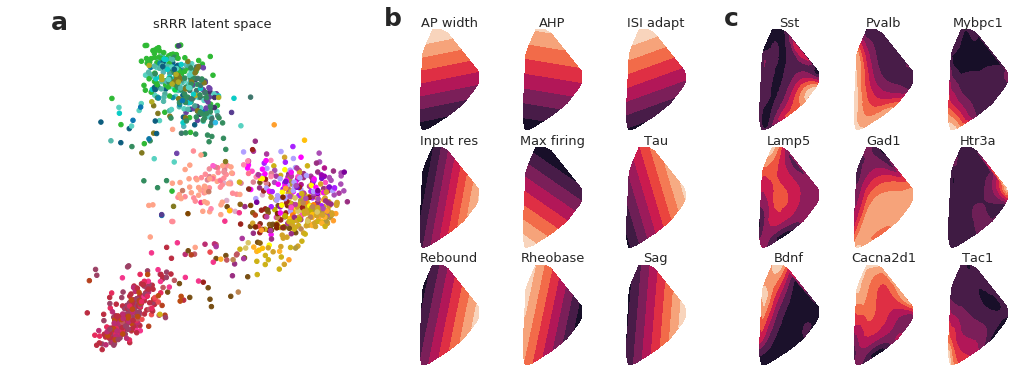

In [254]:
# All in one, for the paper
lasso_id=2
fig = plt.figure(figsize=(16, 5.2))
widths = [3,1,1,1]
heights = [1,1,1]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths,
                          height_ratios=heights)
spec.update(wspace=0, hspace=0.12)

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

    
vx_rank2, vy_rank2 = sparseRRR.elastic_rrr(X, Y, \
                            lambdau=0.34, alpha=1, rank=2, sparsity='row-wise')    
    
# Cell types
ax0 = fig.add_subplot(spec[:, 0])
ax0.scatter((X@vx_rank2)[:, 1], (X@vx_rank2)[:, 0],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes_no_low_qual], s=20)
#ax0.set_aspect('equal', adjustable='box')
ax0.set_title('sRRR latent space', fontsize=13, y=0.99)
ax0.set_xlim([-2.5, 2.5])
ax0.set_xticks([])
ax0.set_yticks([])

# ephys
features = ['AP amp', 'AP amp adapt', 'AP amp CV', 'AP thresh', 'AP width', 'AHP', \
            'ISI adapt', 'ISI CV', 'Input res', 'Max firing', 'Tau', \
            'Rebound', r'$V_m$', 'Rheobase', 'Sag', 'UDR']
ax1 = fig.add_subplot(spec[0, 1])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        4, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax1)
ax2 = fig.add_subplot(spec[0, 2])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        5, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax2)
ax3 = fig.add_subplot(spec[0, 3])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        6, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax3)
ax4 = fig.add_subplot(spec[1, 1])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        8, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax4)
ax5 = fig.add_subplot(spec[1, 2])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        9, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax5)
ax6 = fig.add_subplot(spec[1, 3])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        10, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax6)
ax7 = fig.add_subplot(spec[2, 1])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        11, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax7)
ax8 = fig.add_subplot(spec[2, 2])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        13, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax8)
ax9 = fig.add_subplot(spec[2, 3])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        14, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax9)

spec.tight_layout(fig, rect=[0, 0, 0.64, 1], h_pad=0)

widths = [1,1,1]
heights = [1,1,1]
spec2 = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights)
spec2.update(wspace=0, hspace=0.12)
# genes
# 22, 21, 14, 2, 1, 13, 0, 5, 9
ax10 = fig.add_subplot(spec2[0, 0])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        22, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax10)
ax11 = fig.add_subplot(spec2[0, 1])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        21, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax11)
ax12 = fig.add_subplot(spec2[0, 2])
latent_space_genes_sRRR(X_no_low_qual,  vx_rank2, \
        14, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax12)
ax13 = fig.add_subplot(spec2[1, 0])
latent_space_genes_sRRR(X_no_low_qual,   vx_rank2, \
        2, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax13)
ax14= fig.add_subplot(spec2[1, 1])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        1, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax14)
ax15 = fig.add_subplot(spec2[1, 2])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        13, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax15)
ax16 = fig.add_subplot(spec2[2, 0])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        0, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax16)
ax17 = fig.add_subplot(spec2[2, 1])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        5, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax17)
ax18 = fig.add_subplot(spec2[2, 2])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        9, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax18)
spec2.tight_layout(fig, rect=[0.54, 0, 1, 1], h_pad=0)
#plt.tight_layout()
sns.despine(bottom=True, left=True)
plt.text(0.1, 1.00, 'a', transform = ax0.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.6, 1.04, 'b', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.6, 1.04, 'c', transform = ax10.transAxes, fontsize=25, fontweight='bold')
plt.savefig('Bottleneck_latent_space_all_together_sRRR.png', bbox_inches = 'tight',
    pad_inches = 0)
plt.savefig('Bottleneck_latent_space_all_together_sRRR.pdf', bbox_inches = 'tight',
    pad_inches = 0)